In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import optuna
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [3]:
train_justCondition = pd.read_csv('~/Documents/AmesHousingML/data_cleaning/data_ordinal_normalCondOnly.csv') 
train_condAndGrLivLimits = pd.read_csv('~/Documents/AmesHousingML/data_cleaning/normal_train_withoutGrLivArea1500.csv') 

In [5]:
train_justCondition['NonHouseSF'] = train_justCondition['NonHouseSF'] * -1

In [6]:
train_justCondition['NonHouseSF']

0        6178.0
1        2137.0
2        4222.0
3        6702.0
4        5925.0
         ...   
2387     6950.0
2388    11947.0
2389     3267.0
2390     5999.0
2391     6866.0
Name: NonHouseSF, Length: 2392, dtype: float64

In [26]:
train_condAndGrLivLimits

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
0,856,126000,30,5,60.0,7890,1,1,3,3,0,0,0,19,2,2,0,2,6,6,1939,1950,1,0,13,14,2,0.0,3,3,1,4,4,2,3,238.0,1,0.0,618.0,856.0,1,3,1,3,856,0,0,1.0,0.0,1,0,2,1,3,4,6,1,5,5,1939.0,1,2.0,399.0,4,4,2,0,0,0,0,166,1,3,2010,9,4,1712.0,2.0,166,1944.5,-6178.0,1712.0,21.698352,0.760456,2.103929
1,1049,139500,120,5,42.0,4235,1,1,3,3,0,4,0,7,2,2,4,2,5,5,1984,1984,1,0,6,6,1,149.0,4,3,1,5,4,3,3,552.0,2,393.0,104.0,1049.0,1,3,1,3,1049,0,0,1.0,0.0,2,0,2,1,4,5,6,0,1,1,1984.0,3,1.0,266.0,4,4,2,0,105,0,0,0,1,2,2009,9,4,2098.0,3.0,105,1984.0,-2137.0,2098.0,49.539551,0.991736,2.479339
2,1001,124900,30,1,60.0,6060,1,1,3,3,0,4,0,10,2,2,0,2,5,9,1930,2007,3,0,8,8,2,0.0,4,3,0,4,4,2,2,737.0,1,0.0,100.0,837.0,1,5,1,3,1001,0,0,0.0,0.0,1,0,2,1,4,5,6,0,1,5,1930.0,1,1.0,216.0,4,2,0,154,0,42,86,0,1,11,2007,9,4,1838.0,1.0,282,1968.5,-4222.0,1838.0,30.330033,0.990099,4.653465
3,1039,114000,70,5,80.0,8146,1,1,3,3,0,0,0,18,2,2,0,5,4,8,1900,2003,1,0,8,8,2,0.0,4,4,0,3,4,2,1,0.0,1,0.0,405.0,405.0,1,4,1,3,717,322,0,0.0,0.0,1,0,2,1,3,6,6,0,1,5,1940.0,1,1.0,281.0,4,4,0,0,0,168,0,111,1,5,2009,9,4,1444.0,1.0,279,1951.5,-6702.0,1444.0,17.726492,0.982077,3.424994
4,936,93000,20,6,60.0,6000,1,2,3,0,0,4,1,18,2,2,1,2,4,4,1953,1953,1,0,8,8,2,0.0,2,3,1,3,4,2,1,0.0,1,0.0,936.0,936.0,1,3,0,3,936,0,0,0.0,0.0,1,0,2,1,3,4,3,0,1,5,1974.0,1,2.0,576.0,4,4,2,0,32,112,0,0,1,2,2009,9,4,1872.0,1.0,144,1953.0,-4128.0,1872.0,31.200000,1.000000,2.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,1040,129500,20,5,70.0,11200,1,1,3,3,0,4,0,20,2,2,0,2,5,5,1965,1965,3,0,6,6,2,0.0,3,3,1,4,4,2,3,906.0,1,0.0,134.0,1040.0,1,5,1,3,1040,0,0,1.0,0.0,1,0,3,1,3,5,6,0,1,5,1965.0,1,1.0,384.0,4,4,2,0,0,0,0,0,1,2,2008,9,4,2080.0,2.0,0,1965.0,-9120.0,2080.0,18.571429,0.625000,0.000000
1352,890,115000,190,5,65.0,8450,1,1,3,3,0,4,0,20,5,2,1,2,5,5,1968,1968,1,0,6,6,2,0.0,3,3,1,4,3,3,2,890.0,1,0.0,0.0,890.0,1,4,0,3,890,0,0,1.0,0.0,1,0,3,1,3,5,6,0,1,5,1970.0,1,1.0,308.0,4,4,2,0,0,0,0,0,1,4,2008,9,4,1780.0,2.0,0,1968.0,-6670.0,1780.0,21.065089,0.769231,0.000000
1353,1242,109900,20,5,84.0,17808,1,1,3,3,0,4,0,7,1,2,0,2,4,5,1946,1950,1,0,13,14,2,0.0,3,3,1,4,4,2,1,0.0,1,0.0,484.0,484.0,1,3,0,3,1242,0,0,0.0,0.0,1,0,2,1,3,4,4,0,1,1,1946.0,1,1.0,336.0,4,4,0,0,0,0,0,0,1,7,2007,9,4,1726.0,1.0,0,1948.0,-16082.0,1726.0,9.692273,0.471698,0.000000
1354,816,129800,30,5,60.0,8550,1,1,3,3,0,4,0,13,2,2,0,2,6,8,1934,1950,1,0,8,8,2,0.0,3,3,1,4,4,2,1,574.0,1,0.0,242.0,816.0,1,5,1,3,816,0,0,1.0,0.0,1,0,2,1,3,4,6,1,3,1,1949.0,1,1.0,240.0,4,4,2,228,0,40,0,0,4,7,2006,9,4,1632.0,2.0,268,1942.0,-6918.0,1632.0,19.087719,0.701754,3.134503


In [27]:
masterScores = pd.DataFrame(columns = ['Model', 'r2_5kf_mean', 'rmse_5kf_mean'])

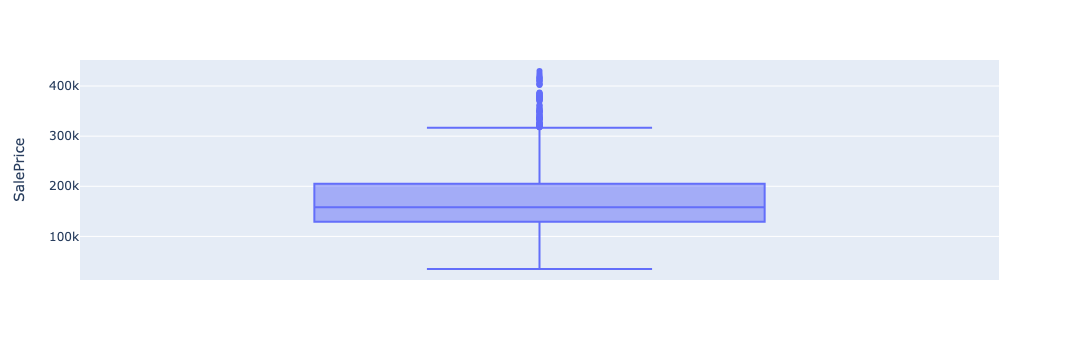

In [28]:
px.box(train_justCondition,y='SalePrice')

In [7]:
#name the model for our scores tracker
model_name = 'catboost_COND'
#train_wOrdinal = train_wOrdinal.drop('PID', axis=1)
    #the features will be X (independent variables)
X = train_justCondition.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = train_justCondition['SalePrice']
y_array = y.values

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    # optuna params {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}
    'iterations': 434,
    'learning_rate': 0.10599212903564667,
    'depth': 5,
    'loss_function': 'RMSE',  # Use appropriate loss function for your task
    'random_seed': 42
                        }

# orig model params = 'iterations': 100,
#     'learning_rate': 0.1,
#     'depth': 6,
#     'loss_function': 'RMSE',  # Use appropriate loss function for your task
#     'random_seed': 42

cat_model = CatBoostRegressor(**params)

# Train the model on the training set
cat_model.fit(X_train, y_train)

# Make predictions on the test set
cat_model_y_pred = cat_model.predict(X_test)

# Evaluate the Random Forest model
cat_model_r2 = r2_score(y_test, cat_model_y_pred)
#print(f'R-squared on the test set: {cat_model_r2}')

cat_model_mse = mean_squared_error(y_test, cat_model_y_pred)
#print(f'Mean Squared Error on the test set: {cat_model_mse}')

# Root Mean Squared Error (RMSE) on the test set
cat_model_rmse = mean_squared_error(y_test, cat_model_y_pred, squared=False)
#print("Root Mean Squared Error (RMSE) on the test set:", cat_model_rmse)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': cat_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('\nFeature Importances:')
print(feature_importances)



# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(cat_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)
# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(cat_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)

0:	learn: 59956.5639563	total: 60.5ms	remaining: 26.2s
1:	learn: 55888.2122102	total: 62.7ms	remaining: 13.5s
2:	learn: 52326.8680206	total: 64.1ms	remaining: 9.2s
3:	learn: 48951.5831697	total: 65.3ms	remaining: 7.02s
4:	learn: 45856.0207103	total: 67.3ms	remaining: 5.77s
5:	learn: 42895.8767166	total: 68.5ms	remaining: 4.89s
6:	learn: 40286.3828407	total: 69.9ms	remaining: 4.26s
7:	learn: 37884.2995183	total: 71.1ms	remaining: 3.79s
8:	learn: 35802.9480015	total: 72.4ms	remaining: 3.42s
9:	learn: 33927.2341913	total: 73.8ms	remaining: 3.13s
10:	learn: 32302.5347863	total: 75.4ms	remaining: 2.9s
11:	learn: 30834.3069662	total: 76.6ms	remaining: 2.69s
12:	learn: 29570.8501951	total: 77.7ms	remaining: 2.52s
13:	learn: 28317.9192995	total: 79ms	remaining: 2.37s
14:	learn: 27320.6950236	total: 80.2ms	remaining: 2.24s
15:	learn: 26333.9054013	total: 81.5ms	remaining: 2.13s
16:	learn: 25489.1802521	total: 82.8ms	remaining: 2.03s
17:	learn: 24720.2521326	total: 83.9ms	remaining: 1.94s
18:	le

NameError: name 'masterScores' is not defined

In [30]:
#name the model for our scores tracker
model_name = 'catboost_GRLIV'
#train_wOrdinal = train_wOrdinal.drop('PID', axis=1)
    #the features will be X (independent variables)
X = train_condAndGrLivLimits.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = train_condAndGrLivLimits['SalePrice']
y_array = y.values

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    # optuna params {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}
    'iterations': 434,
    'learning_rate': 0.10599212903564667,
    'depth': 5,
    'loss_function': 'RMSE',  # Use appropriate loss function for your task
    'random_seed': 42
                        }

# orig model params = 'iterations': 100,
#     'learning_rate': 0.1,
#     'depth': 6,
#     'loss_function': 'RMSE',  # Use appropriate loss function for your task
#     'random_seed': 42

cat_model = CatBoostRegressor(**params)

# Train the model on the training set
cat_model.fit(X_train, y_train)

# Make predictions on the test set
cat_model_y_pred = cat_model.predict(X_test)

# Evaluate the Random Forest model
cat_model_r2 = r2_score(y_test, cat_model_y_pred)
#print(f'R-squared on the test set: {cat_model_r2}')

cat_model_mse = mean_squared_error(y_test, cat_model_y_pred)
#print(f'Mean Squared Error on the test set: {cat_model_mse}')

# Root Mean Squared Error (RMSE) on the test set
cat_model_rmse = mean_squared_error(y_test, cat_model_y_pred, squared=False)
#print("Root Mean Squared Error (RMSE) on the test set:", cat_model_rmse)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': cat_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('\nFeature Importances:')
print(feature_importances)



# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(cat_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)
# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(cat_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)

0:	learn: 34465.2947564	total: 950us	remaining: 412ms
1:	learn: 32181.1051236	total: 1.95ms	remaining: 422ms
2:	learn: 30112.8370667	total: 2.95ms	remaining: 423ms
3:	learn: 28446.0454127	total: 3.82ms	remaining: 410ms
4:	learn: 26935.6925025	total: 4.67ms	remaining: 401ms
5:	learn: 25617.9109103	total: 5.53ms	remaining: 395ms
6:	learn: 24398.2258244	total: 6.46ms	remaining: 394ms
7:	learn: 23264.4491925	total: 7.42ms	remaining: 395ms
8:	learn: 22113.6380608	total: 8.35ms	remaining: 394ms
9:	learn: 21124.3923581	total: 9.22ms	remaining: 391ms
10:	learn: 20342.9600970	total: 10.1ms	remaining: 389ms
11:	learn: 19594.4067425	total: 11ms	remaining: 385ms
12:	learn: 19008.0757119	total: 11.8ms	remaining: 381ms
13:	learn: 18367.7005301	total: 12.6ms	remaining: 378ms
14:	learn: 17818.4991952	total: 13.5ms	remaining: 377ms
15:	learn: 17294.4894482	total: 14.5ms	remaining: 380ms
16:	learn: 16923.2757682	total: 15.4ms	remaining: 379ms
17:	learn: 16525.1535458	total: 16.8ms	remaining: 388ms
18:	l

In [35]:
masterScores #want to use the sci kit and catboost

# without outliers
# catboost_COND = 0.946168
# catboost_GRLIV = 0.893810

,Model,r2_5kf_mean,rmse_5kf_mean
0,catboost_COND,0.94134,15496.236485
1,catboost_GRLIV,0.89650,11726.786449
2,catboost_COND,0.94134,15496.236485


In [32]:
# output_file = 'masterScores_catboost.csv'

# masterScores.to_csv(output_file, index=False, mode='w')

# print(f"DataFrame exported to '{output_file}' in the same working directory.")

In [33]:
c + a

NameError: name 'c' is not defined

In [36]:

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
    }

    model = CatBoostRegressor(**params, random_state=42)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=10)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
# best_params = {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}
#best_model = CatBoostRegressor(**best_params, random_state=42)
#best_model.fit(X_train, y_train)

[I 2024-02-01 08:39:38,866] A new study created in memory with name: no-name-1040813d-60ff-4ed6-999d-ba5b9b63476b


0:	learn: 61250.6649320	test: 58956.9794514	best: 58956.9794514 (0)	total: 3.22ms	remaining: 1.41s
10:	learn: 38026.3067583	test: 35357.6697193	best: 35357.6697193 (10)	total: 30ms	remaining: 1.17s
20:	learn: 26942.5998732	test: 24610.6503945	best: 24610.6503945 (20)	total: 49.8ms	remaining: 993ms
30:	learn: 21756.2851123	test: 20240.1152451	best: 20240.1152451 (30)	total: 66.7ms	remaining: 880ms
40:	learn: 18968.7968843	test: 18051.2350817	best: 18051.2350817 (40)	total: 150ms	remaining: 1.46s
50:	learn: 17314.1167624	test: 17165.5549380	best: 17165.5549380 (50)	total: 239ms	remaining: 1.82s
60:	learn: 16122.9368754	test: 16563.0201513	best: 16563.0201513 (60)	total: 295ms	remaining: 1.83s
70:	learn: 15342.1147650	test: 16267.5846040	best: 16267.5846040 (70)	total: 310ms	remaining: 1.61s
80:	learn: 14549.8703965	test: 15947.4433926	best: 15947.4433926 (80)	total: 323ms	remaining: 1.43s
90:	learn: 14010.8140235	test: 15802.2931564	best: 15802.2931564 (90)	total: 337ms	remaining: 1.29s


[I 2024-02-01 08:39:39,693] Trial 0 finished with value: 211159446.30703473 and parameters: {'iterations': 440, 'learning_rate': 0.07574867922016289, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


310:	learn: 7928.0643366	test: 14716.3242805	best: 14716.3242805 (310)	total: 649ms	remaining: 269ms
320:	learn: 7763.3006539	test: 14671.1125416	best: 14671.1125416 (320)	total: 664ms	remaining: 246ms
330:	learn: 7610.2078202	test: 14646.7298374	best: 14646.7298374 (330)	total: 679ms	remaining: 224ms
340:	learn: 7499.6946296	test: 14630.9000006	best: 14630.9000006 (340)	total: 693ms	remaining: 201ms
350:	learn: 7350.5073013	test: 14580.8557225	best: 14580.8557225 (350)	total: 709ms	remaining: 180ms
360:	learn: 7256.1670538	test: 14565.6362651	best: 14565.6362651 (360)	total: 723ms	remaining: 158ms
370:	learn: 7126.1387347	test: 14542.0979315	best: 14542.0979315 (370)	total: 738ms	remaining: 137ms
380:	learn: 7014.2213487	test: 14531.3263781	best: 14531.3263781 (380)	total: 752ms	remaining: 116ms
390:	learn: 6914.1743381	test: 14538.7587859	best: 14531.3263781 (380)	total: 767ms	remaining: 96.1ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14531.32638
bestIteratio

[I 2024-02-01 08:39:40,269] Trial 1 finished with value: 252934301.5963249 and parameters: {'iterations': 326, 'learning_rate': 0.2208976570908805, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.
[I 2024-02-01 08:39:40,379] Trial 2 finished with value: 252480817.114241 and parameters: {'iterations': 466, 'learning_rate': 0.14993659597490414, 'depth': 5}. Best is trial 0 with value: 211159446.30703473.


90:	learn: 5613.8324498	test: 15951.2755528	best: 15903.9083749 (83)	total: 541ms	remaining: 1.4s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15903.90837
bestIteration = 83

Shrink model to first 84 iterations.
0:	learn: 58080.1041878	test: 55714.5484008	best: 55714.5484008 (0)	total: 1.23ms	remaining: 571ms
10:	learn: 26970.7408240	test: 24687.2913467	best: 24687.2913467 (10)	total: 11.1ms	remaining: 458ms
20:	learn: 19848.3079608	test: 18737.6963497	best: 18737.6963497 (20)	total: 21.5ms	remaining: 455ms
30:	learn: 17200.0659212	test: 17420.5194052	best: 17420.5194052 (30)	total: 31.7ms	remaining: 444ms
40:	learn: 15834.8348600	test: 17087.3028546	best: 17087.3028546 (40)	total: 41.4ms	remaining: 429ms
50:	learn: 14767.1605989	test: 16623.2994258	best: 16623.2994258 (50)	total: 51.5ms	remaining: 419ms
60:	learn: 13880.4256051	test: 16282.1076969	best: 16282.1076969 (60)	total: 61.2ms	remaining: 406ms
70:	learn: 13114.6047901	test: 16182.0620752	best: 16182.06207

[I 2024-02-01 08:39:40,578] Trial 3 finished with value: 252556860.87589967 and parameters: {'iterations': 299, 'learning_rate': 0.261078368433414, 'depth': 5}. Best is trial 0 with value: 211159446.30703473.


40:	learn: 13583.1166690	test: 17233.8506336	best: 17232.3871701 (39)	total: 68.1ms	remaining: 429ms
50:	learn: 12407.3787844	test: 16868.1575340	best: 16788.4779542 (48)	total: 91.2ms	remaining: 444ms
60:	learn: 11579.2703832	test: 16693.9267893	best: 16685.9611694 (59)	total: 102ms	remaining: 396ms
70:	learn: 10902.1048838	test: 16518.2928732	best: 16516.1485864 (69)	total: 112ms	remaining: 359ms
80:	learn: 10423.6195421	test: 16360.4459811	best: 16360.4459811 (80)	total: 122ms	remaining: 328ms
90:	learn: 9785.5664704	test: 16218.0694536	best: 16207.3181291 (86)	total: 132ms	remaining: 301ms
100:	learn: 9183.1910941	test: 16062.8954555	best: 16062.8954555 (100)	total: 143ms	remaining: 281ms
110:	learn: 8740.4389815	test: 15993.3539021	best: 15993.3539021 (110)	total: 154ms	remaining: 261ms
120:	learn: 8344.6251832	test: 15928.0441138	best: 15928.0441138 (120)	total: 164ms	remaining: 242ms
130:	learn: 8049.3475791	test: 15905.6242992	best: 15905.6242992 (130)	total: 175ms	remaining: 2

[I 2024-02-01 08:39:42,275] Trial 4 finished with value: 238393405.8115416 and parameters: {'iterations': 409, 'learning_rate': 0.14539563797200578, 'depth': 10}. Best is trial 0 with value: 211159446.30703473.


160:	learn: 3598.1726674	test: 15445.9515044	best: 15445.9515044 (160)	total: 1.54s	remaining: 2.37s
170:	learn: 3208.5864286	test: 15461.3357363	best: 15439.9937115 (164)	total: 1.63s	remaining: 2.27s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15439.99371
bestIteration = 164

Shrink model to first 165 iterations.
0:	learn: 59320.7113112	test: 56935.0850039	best: 56935.0850039 (0)	total: 745us	remaining: 333ms
10:	learn: 31244.6472319	test: 29020.7266918	best: 29020.7266918 (10)	total: 9.04ms	remaining: 359ms
20:	learn: 22502.0740383	test: 20625.4944237	best: 20625.4944237 (20)	total: 16.6ms	remaining: 337ms
30:	learn: 19118.3361612	test: 17880.5348075	best: 17880.5348075 (30)	total: 24ms	remaining: 323ms
40:	learn: 17440.5122272	test: 17022.3541750	best: 17022.3541750 (40)	total: 31.8ms	remaining: 316ms
50:	learn: 16389.7810672	test: 16571.6866603	best: 16571.6866603 (50)	total: 39.6ms	remaining: 308ms
60:	learn: 15554.8468804	test: 16359.0065969	best: 16359.006

[I 2024-02-01 08:39:42,374] Trial 5 finished with value: 247717381.88994548 and parameters: {'iterations': 448, 'learning_rate': 0.12099470601045356, 'depth': 4}. Best is trial 0 with value: 211159446.30703473.


70:	learn: 14900.7908236	test: 16177.2252808	best: 16175.7043673 (68)	total: 54.2ms	remaining: 288ms
80:	learn: 14236.1037875	test: 15943.3559971	best: 15943.3559971 (80)	total: 62.4ms	remaining: 283ms
90:	learn: 13869.1958443	test: 15876.8286563	best: 15876.8286563 (90)	total: 70ms	remaining: 275ms
100:	learn: 13443.1693986	test: 15772.5911340	best: 15771.7252495 (99)	total: 77.4ms	remaining: 266ms
110:	learn: 13114.2376811	test: 15799.5196906	best: 15739.0400562 (104)	total: 86ms	remaining: 261ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15739.04006
bestIteration = 104

Shrink model to first 105 iterations.
0:	learn: 55602.4429131	test: 53611.5157283	best: 53611.5157283 (0)	total: 10.3ms	remaining: 2.9s
10:	learn: 20730.2406726	test: 20904.2651874	best: 20904.2651874 (10)	total: 88.7ms	remaining: 2.18s
20:	learn: 14825.0219042	test: 17297.3980444	best: 17297.3980444 (20)	total: 157ms	remaining: 1.95s
30:	learn: 12290.1827661	test: 16656.0729450	best: 16656.072

[I 2024-02-01 08:39:42,970] Trial 6 finished with value: 245674485.13538116 and parameters: {'iterations': 282, 'learning_rate': 0.20857694913669725, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.
[I 2024-02-01 08:39:43,069] Trial 7 finished with value: 243622527.79552826 and parameters: {'iterations': 319, 'learning_rate': 0.21353895234804293, 'depth': 4}. Best is trial 0 with value: 211159446.30703473.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 15674.00667
bestIteration = 74

Shrink model to first 75 iterations.
0:	learn: 55444.4404992	test: 53056.9467680	best: 53056.9467680 (0)	total: 843us	remaining: 268ms
10:	learn: 22726.4949865	test: 21045.5762862	best: 21045.5762862 (10)	total: 8.99ms	remaining: 252ms
20:	learn: 18131.1792322	test: 17812.3382519	best: 17812.3382519 (20)	total: 17.9ms	remaining: 253ms
30:	learn: 16342.4265507	test: 16844.8746911	best: 16844.8746911 (30)	total: 25.8ms	remaining: 239ms
40:	learn: 15174.4824127	test: 16411.5429989	best: 16411.5429989 (40)	total: 34.3ms	remaining: 232ms
50:	learn: 14181.2208243	test: 16162.8034799	best: 16162.8034799 (50)	total: 42.9ms	remaining: 226ms
60:	learn: 13543.0734059	test: 16122.9797703	best: 16122.9797703 (60)	total: 50.8ms	remaining: 215ms
70:	learn: 12857.8427059	test: 15875.1407355	best: 15850.5194737 (67)	total: 58.4ms	remaining: 204ms
80:	learn: 12327.0955728	test: 15823.6670238	best: 15792.454

[I 2024-02-01 08:39:43,376] Trial 8 finished with value: 233801715.25238413 and parameters: {'iterations': 143, 'learning_rate': 0.2946379963446941, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


30:	learn: 11345.7500304	test: 15987.9081938	best: 15987.9081938 (30)	total: 103ms	remaining: 371ms
40:	learn: 9994.9310785	test: 15551.0697203	best: 15551.0697203 (40)	total: 135ms	remaining: 335ms
50:	learn: 8572.4781302	test: 15459.6481370	best: 15459.6481370 (50)	total: 167ms	remaining: 301ms
60:	learn: 7323.8160005	test: 15371.2959206	best: 15360.0323189 (58)	total: 200ms	remaining: 269ms
70:	learn: 6413.0661792	test: 15298.2792284	best: 15298.2792284 (70)	total: 232ms	remaining: 235ms
80:	learn: 5752.6578377	test: 15297.6243420	best: 15290.5760275 (79)	total: 265ms	remaining: 203ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15290.57603
bestIteration = 79

Shrink model to first 80 iterations.
0:	learn: 62354.4407433	test: 60090.1137966	best: 60090.1137966 (0)	total: 10.1ms	remaining: 4.14s
10:	learn: 44347.5197813	test: 42620.1926022	best: 42620.1926022 (10)	total: 104ms	remaining: 3.77s
20:	learn: 32863.7027555	test: 31658.4170207	best: 31658.4170207 (20)	t

[I 2024-02-01 08:39:45,646] Trial 9 finished with value: 236526943.93939775 and parameters: {'iterations': 409, 'learning_rate': 0.05215603131270843, 'depth': 10}. Best is trial 0 with value: 211159446.30703473.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 15379.4325
bestIteration = 227

Shrink model to first 228 iterations.
0:	learn: 63988.3550347	test: 61632.3705205	best: 61632.3705205 (0)	total: 2.16ms	remaining: 332ms
10:	learn: 58049.4502808	test: 55626.4031047	best: 55626.4031047 (10)	total: 22.2ms	remaining: 291ms
20:	learn: 52850.8690239	test: 50384.1008778	best: 50384.1008778 (20)	total: 42.7ms	remaining: 272ms
30:	learn: 48367.9326710	test: 45874.1906336	best: 45874.1906336 (30)	total: 63.6ms	remaining: 254ms
40:	learn: 44365.2567762	test: 41880.0109511	best: 41880.0109511 (40)	total: 83.3ms	remaining: 232ms
50:	learn: 40864.5676683	test: 38388.3715383	best: 38388.3715383 (50)	total: 105ms	remaining: 214ms
60:	learn: 37775.4195833	test: 35364.2001330	best: 35364.2001330 (60)	total: 126ms	remaining: 194ms
70:	learn: 35104.6628710	test: 32749.0604066	best: 32749.0604066 (70)	total: 147ms	remaining: 174ms
80:	learn: 32765.5934792	test: 30546.6577825	best: 30546.6577

[I 2024-02-01 08:39:45,992] Trial 10 finished with value: 443508338.17225826 and parameters: {'iterations': 155, 'learning_rate': 0.013720529069171594, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


90:	learn: 30695.7871638	test: 28584.5489249	best: 28584.5489249 (90)	total: 190ms	remaining: 134ms
100:	learn: 28897.3211354	test: 26882.9796914	best: 26882.9796914 (100)	total: 211ms	remaining: 113ms
110:	learn: 27313.9773848	test: 25399.9691282	best: 25399.9691282 (110)	total: 233ms	remaining: 92.5ms
120:	learn: 25912.4133217	test: 24109.6578986	best: 24109.6578986 (120)	total: 254ms	remaining: 71.5ms
130:	learn: 24712.5999739	test: 23060.0395205	best: 23060.0395205 (130)	total: 275ms	remaining: 50.4ms
140:	learn: 23623.6651984	test: 22117.1165989	best: 22117.1165989 (140)	total: 297ms	remaining: 29.5ms
150:	learn: 22649.2931980	test: 21333.3332305	best: 21333.3332305 (150)	total: 318ms	remaining: 8.41ms
154:	learn: 22301.9702070	test: 21059.6376553	best: 21059.6376553 (154)	total: 326ms	remaining: 0us

bestTest = 21059.63766
bestIteration = 154

0:	learn: 51907.7334438	test: 49939.5513793	best: 49939.5513793 (0)	total: 2.34ms	remaining: 159ms
10:	learn: 17979.2382721	test: 18300.36

[I 2024-02-01 08:39:46,155] Trial 11 finished with value: 252030914.02401966 and parameters: {'iterations': 69, 'learning_rate': 0.29905868605889435, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


30:	learn: 12517.6417544	test: 16202.2229198	best: 16202.2229198 (30)	total: 68.7ms	remaining: 84.2ms
40:	learn: 10950.3189723	test: 16200.2198831	best: 16097.2277518 (34)	total: 89.4ms	remaining: 61.1ms
50:	learn: 9787.8013979	test: 15970.1931539	best: 15934.1437474 (48)	total: 110ms	remaining: 38.9ms
60:	learn: 8818.9225543	test: 15934.4447540	best: 15907.2114852 (53)	total: 131ms	remaining: 17.2ms
68:	learn: 8200.3383829	test: 15875.4815368	best: 15875.4815368 (68)	total: 147ms	remaining: 0us

bestTest = 15875.48154
bestIteration = 68

0:	learn: 60875.5292350	test: 58591.0544517	best: 58591.0544517 (0)	total: 1.8ms	remaining: 329ms
10:	learn: 36130.7594680	test: 33452.4294384	best: 33452.4294384 (10)	total: 15.7ms	remaining: 247ms
20:	learn: 25238.3259711	test: 23080.4493112	best: 23080.4493112 (20)	total: 30.3ms	remaining: 235ms
30:	learn: 20432.4183483	test: 19326.1787157	best: 19326.1787157 (30)	total: 44.4ms	remaining: 219ms
40:	learn: 17881.4177565	test: 17627.4828578	best: 176

[I 2024-02-01 08:39:46,438] Trial 12 finished with value: 230951870.2155903 and parameters: {'iterations': 184, 'learning_rate': 0.08434148290038643, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


80:	learn: 13905.0189933	test: 15931.4077530	best: 15911.6743428 (79)	total: 114ms	remaining: 145ms
90:	learn: 13439.7593350	test: 15842.9560707	best: 15842.9560707 (90)	total: 129ms	remaining: 132ms
100:	learn: 12870.9663401	test: 15688.7171586	best: 15688.7171586 (100)	total: 143ms	remaining: 118ms
110:	learn: 12446.5684029	test: 15604.4414402	best: 15604.4414402 (110)	total: 157ms	remaining: 103ms
120:	learn: 12037.5845275	test: 15532.7896456	best: 15532.7896456 (120)	total: 171ms	remaining: 88.9ms
130:	learn: 11710.8749353	test: 15450.3894784	best: 15449.1739625 (129)	total: 185ms	remaining: 74.7ms
140:	learn: 11425.3195124	test: 15401.1961695	best: 15401.1961695 (140)	total: 200ms	remaining: 60.9ms
150:	learn: 11145.6026854	test: 15327.2281845	best: 15322.3694232 (148)	total: 217ms	remaining: 47.4ms
160:	learn: 10831.2231850	test: 15261.0076534	best: 15261.0076534 (160)	total: 231ms	remaining: 33ms
170:	learn: 10639.2141577	test: 15260.5387173	best: 15249.5395114 (165)	total: 245m

[I 2024-02-01 08:39:46,659] Trial 13 finished with value: 242635339.62872913 and parameters: {'iterations': 198, 'learning_rate': 0.08745552519372307, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


20:	learn: 24792.1806128	test: 22840.7296373	best: 22840.7296373 (20)	total: 36.1ms	remaining: 304ms
30:	learn: 20221.0080559	test: 19399.0928850	best: 19399.0928850 (30)	total: 50.3ms	remaining: 271ms
40:	learn: 17731.9829227	test: 17760.6293063	best: 17760.6293063 (40)	total: 64.6ms	remaining: 247ms
50:	learn: 16281.2915267	test: 17167.1911364	best: 17167.1911364 (50)	total: 78.8ms	remaining: 227ms
60:	learn: 15190.5314747	test: 16720.5959513	best: 16720.5959513 (60)	total: 93.1ms	remaining: 209ms
70:	learn: 14385.0778450	test: 16405.7730560	best: 16405.7730560 (70)	total: 107ms	remaining: 192ms
80:	learn: 13694.0323937	test: 16197.6452257	best: 16196.0921024 (79)	total: 121ms	remaining: 175ms
90:	learn: 13103.9726841	test: 15995.1071024	best: 15988.9590885 (89)	total: 135ms	remaining: 158ms
100:	learn: 12579.7580610	test: 15845.4999734	best: 15839.2621545 (99)	total: 148ms	remaining: 143ms
110:	learn: 12197.6756912	test: 15733.2550819	best: 15733.2550819 (110)	total: 162ms	remaining

[I 2024-02-01 08:39:46,981] Trial 14 finished with value: 228441786.70114455 and parameters: {'iterations': 208, 'learning_rate': 0.07911932603798708, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


160:	learn: 11194.7706668	test: 15385.2945104	best: 15380.2005428 (159)	total: 235ms	remaining: 68.7ms
170:	learn: 10893.1408361	test: 15347.2348187	best: 15347.2348187 (170)	total: 250ms	remaining: 54.1ms
180:	learn: 10623.4813461	test: 15290.0189304	best: 15290.0189304 (180)	total: 265ms	remaining: 39.5ms
190:	learn: 10378.9329167	test: 15211.4021777	best: 15211.4021777 (190)	total: 279ms	remaining: 24.9ms
200:	learn: 10130.6657710	test: 15157.9750385	best: 15144.8407243 (198)	total: 293ms	remaining: 10.2ms
207:	learn: 9976.1087825	test: 15118.9573967	best: 15114.2908104 (205)	total: 303ms	remaining: 0us

bestTest = 15114.29081
bestIteration = 205

Shrink model to first 206 iterations.
0:	learn: 64020.1475780	test: 61661.0886091	best: 61661.0886091 (0)	total: 1.69ms	remaining: 372ms
10:	learn: 58489.1028323	test: 56070.8547987	best: 56070.8547987 (10)	total: 15.1ms	remaining: 291ms
20:	learn: 53603.4742081	test: 51160.2306620	best: 51160.2306620 (20)	total: 29.8ms	remaining: 285ms
30

[I 2024-02-01 08:39:47,320] Trial 15 finished with value: 343814489.23838127 and parameters: {'iterations': 222, 'learning_rate': 0.012960342520921597, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


90:	learn: 31946.8942110	test: 29603.2972417	best: 29603.2972417 (90)	total: 130ms	remaining: 188ms
100:	learn: 30164.7651306	test: 27903.5373019	best: 27903.5373019 (100)	total: 145ms	remaining: 173ms
110:	learn: 28604.1433233	test: 26405.0153323	best: 26405.0153323 (110)	total: 158ms	remaining: 158ms
120:	learn: 27191.3324451	test: 25057.1094370	best: 25057.1094370 (120)	total: 173ms	remaining: 144ms
130:	learn: 25989.2981907	test: 23967.5781478	best: 23967.5781478 (130)	total: 187ms	remaining: 130ms
140:	learn: 24931.9783289	test: 23047.9185423	best: 23047.9185423 (140)	total: 201ms	remaining: 116ms
150:	learn: 23961.0659366	test: 22174.8331993	best: 22174.8331993 (150)	total: 215ms	remaining: 101ms
160:	learn: 23097.6283388	test: 21442.4752777	best: 21442.4752777 (160)	total: 229ms	remaining: 86.9ms
170:	learn: 22321.4213420	test: 20790.8674499	best: 20790.8674499 (170)	total: 244ms	remaining: 72.9ms
180:	learn: 21600.7799821	test: 20166.8773669	best: 20166.8773669 (180)	total: 259

[I 2024-02-01 08:39:47,547] Trial 16 finished with value: 232751254.43575892 and parameters: {'iterations': 379, 'learning_rate': 0.07504077455925762, 'depth': 5}. Best is trial 0 with value: 211159446.30703473.


190:	learn: 11408.5932957	test: 15256.1874148	best: 15256.1874148 (190)	total: 200ms	remaining: 196ms
200:	learn: 11199.9990613	test: 15283.1928393	best: 15256.1874148 (190)	total: 210ms	remaining: 186ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15256.18741
bestIteration = 190

Shrink model to first 191 iterations.
0:	learn: 59607.8042378	test: 57386.0280267	best: 57386.0280267 (0)	total: 5.23ms	remaining: 2.59s
10:	learn: 29999.1536887	test: 28603.6181753	best: 28603.6181753 (10)	total: 38.2ms	remaining: 1.68s
20:	learn: 20123.7805578	test: 19831.9471813	best: 19831.9471813 (20)	total: 74.7ms	remaining: 1.69s
30:	learn: 16400.0734420	test: 17398.9410154	best: 17398.9410154 (30)	total: 107ms	remaining: 1.61s
40:	learn: 14469.8992719	test: 16560.7024654	best: 16560.7024654 (40)	total: 139ms	remaining: 1.54s
50:	learn: 13146.9218714	test: 16192.2789068	best: 16192.2789068 (50)	total: 172ms	remaining: 1.5s
60:	learn: 12159.2867034	test: 15853.9755440	best: 15853.97

[I 2024-02-01 08:39:48,155] Trial 17 finished with value: 216560609.94550747 and parameters: {'iterations': 496, 'learning_rate': 0.11354609489422367, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


120:	learn: 8528.6256654	test: 14854.1028632	best: 14854.1028632 (120)	total: 407ms	remaining: 1.26s
130:	learn: 8073.0462692	test: 14806.9397266	best: 14785.7560019 (129)	total: 441ms	remaining: 1.23s
140:	learn: 7653.2524391	test: 14747.5394260	best: 14747.5394260 (140)	total: 475ms	remaining: 1.2s
150:	learn: 7210.6878973	test: 14741.1296495	best: 14738.6616854 (143)	total: 518ms	remaining: 1.18s
160:	learn: 6896.6249466	test: 14719.9140370	best: 14715.9984352 (158)	total: 559ms	remaining: 1.16s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14715.99844
bestIteration = 158

Shrink model to first 159 iterations.
0:	learn: 59309.7475705	test: 57097.7441598	best: 57097.7441598 (0)	total: 4.84ms	remaining: 2.42s
10:	learn: 28781.9547994	test: 27181.8145523	best: 27181.8145523 (10)	total: 40.4ms	remaining: 1.8s
20:	learn: 19607.5945801	test: 19314.7048938	best: 19314.7048938 (20)	total: 78ms	remaining: 1.78s
30:	learn: 16174.2257872	test: 17163.7127544	best: 17163.7127

[I 2024-02-01 08:39:48,830] Trial 18 finished with value: 216475504.46544296 and parameters: {'iterations': 500, 'learning_rate': 0.1204428420598545, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


0:	learn: 56663.1621367	test: 54542.6539922	best: 54542.6539922 (0)	total: 5.88ms	remaining: 2.16s
10:	learn: 22371.3270514	test: 21905.6591969	best: 21905.6591969 (10)	total: 42.6ms	remaining: 1.38s
20:	learn: 15934.4998984	test: 17517.5451081	best: 17517.5451081 (20)	total: 81.1ms	remaining: 1.34s
30:	learn: 13739.5925438	test: 16678.2560155	best: 16660.8702325 (29)	total: 124ms	remaining: 1.35s
40:	learn: 12282.0704479	test: 16004.0231658	best: 16004.0231658 (40)	total: 158ms	remaining: 1.26s
50:	learn: 10912.4668395	test: 15681.9372073	best: 15681.9372073 (50)	total: 190ms	remaining: 1.19s


[I 2024-02-01 08:39:49,239] Trial 19 finished with value: 227372115.28173426 and parameters: {'iterations': 369, 'learning_rate': 0.18236202898478, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


60:	learn: 10006.1648535	test: 15491.8321986	best: 15461.3164063 (58)	total: 222ms	remaining: 1.12s
70:	learn: 9080.4830863	test: 15310.1796097	best: 15310.1796097 (70)	total: 255ms	remaining: 1.07s
80:	learn: 8403.0093319	test: 15192.7477659	best: 15192.7477659 (80)	total: 287ms	remaining: 1.02s
90:	learn: 7769.1466257	test: 15134.0149685	best: 15119.8980838 (88)	total: 319ms	remaining: 974ms
100:	learn: 7169.1154576	test: 15096.2183888	best: 15082.6482881 (93)	total: 351ms	remaining: 931ms
110:	learn: 6683.9576602	test: 15105.9540854	best: 15078.8631959 (101)	total: 383ms	remaining: 891ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15078.8632
bestIteration = 101

Shrink model to first 102 iterations.
0:	learn: 62784.3536313	test: 60461.0423751	best: 60461.0423751 (0)	total: 1.95ms	remaining: 972ms
10:	learn: 47321.7546708	test: 44848.3507904	best: 44848.3507904 (10)	total: 21.9ms	remaining: 973ms
20:	learn: 37076.7863220	test: 34606.5322525	best: 34606.5322525 (

[I 2024-02-01 08:39:49,930] Trial 20 finished with value: 220040562.73030126 and parameters: {'iterations': 500, 'learning_rate': 0.040975995513057195, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


310:	learn: 9909.7957191	test: 14839.4482393	best: 14833.7642805 (308)	total: 647ms	remaining: 393ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14833.76428
bestIteration = 308

Shrink model to first 309 iterations.
0:	learn: 59180.1110487	test: 56972.3897003	best: 56972.3897003 (0)	total: 4.67ms	remaining: 2.3s
10:	learn: 28410.3621111	test: 27007.8104376	best: 27007.8104376 (10)	total: 40.3ms	remaining: 1.77s
20:	learn: 19239.8476940	test: 19157.6683970	best: 19157.6683970 (20)	total: 73ms	remaining: 1.64s
30:	learn: 15881.2000504	test: 17131.6650999	best: 17131.6650999 (30)	total: 105ms	remaining: 1.56s
40:	learn: 14081.0810458	test: 16337.7279484	best: 16337.7279484 (40)	total: 137ms	remaining: 1.51s
50:	learn: 12911.9311104	test: 15965.9599010	best: 15965.9599010 (50)	total: 169ms	remaining: 1.46s
60:	learn: 12081.7214094	test: 15717.8715407	best: 15717.8715407 (60)	total: 202ms	remaining: 1.43s
70:	learn: 11166.8714694	test: 15299.3272663	best: 15299.3272663

[I 2024-02-01 08:39:50,437] Trial 21 finished with value: 219112780.4864081 and parameters: {'iterations': 494, 'learning_rate': 0.12344705025472713, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


120:	learn: 8141.5057417	test: 14945.4861135	best: 14926.8665792 (114)	total: 395ms	remaining: 1.22s
130:	learn: 7655.3444939	test: 14870.4390278	best: 14870.4390278 (130)	total: 428ms	remaining: 1.19s
140:	learn: 7244.8720307	test: 14819.0712661	best: 14802.4585960 (138)	total: 460ms	remaining: 1.15s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14802.4586
bestIteration = 138

Shrink model to first 139 iterations.
0:	learn: 59785.4051255	test: 57604.0255060	best: 57604.0255060 (0)	total: 9.67ms	remaining: 4.25s
10:	learn: 30769.3198801	test: 29496.9420930	best: 29496.9420930 (10)	total: 70ms	remaining: 2.74s
20:	learn: 20451.9167804	test: 20717.6657884	best: 20717.6657884 (20)	total: 130ms	remaining: 2.59s
30:	learn: 16220.4343302	test: 18152.1902858	best: 18152.1902858 (30)	total: 187ms	remaining: 2.48s
40:	learn: 14062.8955487	test: 17222.2196044	best: 17222.2196044 (40)	total: 248ms	remaining: 2.42s
50:	learn: 12690.5533129	test: 16759.8032084	best: 16759.803208

[I 2024-02-01 08:39:51,471] Trial 22 finished with value: 242158161.78490835 and parameters: {'iterations': 441, 'learning_rate': 0.10999960155283026, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.


140:	learn: 6684.0881664	test: 15604.8662986	best: 15604.8662986 (140)	total: 839ms	remaining: 1.78s
150:	learn: 6266.7749900	test: 15578.5845117	best: 15573.8750965 (149)	total: 897ms	remaining: 1.72s
160:	learn: 5877.2265686	test: 15562.6603849	best: 15561.4318681 (159)	total: 955ms	remaining: 1.66s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15561.43187
bestIteration = 159

Shrink model to first 160 iterations.
0:	learn: 57117.4962702	test: 54980.6394192	best: 54980.6394192 (0)	total: 5.8ms	remaining: 2.7s
10:	learn: 22976.2175910	test: 22150.4336965	best: 22150.4336965 (10)	total: 41.6ms	remaining: 1.72s
20:	learn: 16252.1466917	test: 17596.1642047	best: 17596.1642047 (20)	total: 74.1ms	remaining: 1.57s
30:	learn: 13902.7622799	test: 16633.0171940	best: 16608.9496594 (29)	total: 107ms	remaining: 1.5s
40:	learn: 12471.7683072	test: 16035.3871426	best: 16035.3871426 (40)	total: 140ms	remaining: 1.46s
50:	learn: 11346.7313337	test: 15692.4278355	best: 15692.42783

[I 2024-02-01 08:39:51,902] Trial 23 finished with value: 230640573.96078214 and parameters: {'iterations': 466, 'learning_rate': 0.171640093707643, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


80:	learn: 8974.4574086	test: 15437.9701212	best: 15422.6620613 (79)	total: 273ms	remaining: 1.3s
90:	learn: 8175.1821516	test: 15379.1956218	best: 15379.1956218 (90)	total: 305ms	remaining: 1.26s
100:	learn: 7520.6584905	test: 15299.0901188	best: 15284.7266766 (99)	total: 337ms	remaining: 1.22s
110:	learn: 6972.2151671	test: 15226.4567867	best: 15225.0549198 (109)	total: 370ms	remaining: 1.18s
120:	learn: 6509.8710718	test: 15207.2055263	best: 15186.8553019 (112)	total: 404ms	remaining: 1.15s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15186.8553
bestIteration = 112

Shrink model to first 113 iterations.
0:	learn: 59728.3689512	test: 57492.7482141	best: 57492.7482141 (0)	total: 2.12ms	remaining: 857ms
10:	learn: 30293.0895425	test: 28309.4044990	best: 28309.4044990 (10)	total: 22.8ms	remaining: 819ms
20:	learn: 20861.0471610	test: 19942.0977288	best: 19942.0977288 (20)	total: 44.1ms	remaining: 809ms
30:	learn: 17270.3235509	test: 17592.3238771	best: 17592.3238771

[I 2024-02-01 08:39:52,380] Trial 24 finished with value: 221940790.24266043 and parameters: {'iterations': 406, 'learning_rate': 0.11110733869770645, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


130:	learn: 9092.2918062	test: 15252.0491446	best: 15252.0491446 (130)	total: 278ms	remaining: 583ms
140:	learn: 8689.0854267	test: 15204.9312011	best: 15196.9476316 (136)	total: 299ms	remaining: 561ms
150:	learn: 8414.3695248	test: 15161.3791468	best: 15159.0382363 (149)	total: 319ms	remaining: 538ms
160:	learn: 8105.2161047	test: 15157.4019160	best: 15135.8961678 (153)	total: 340ms	remaining: 517ms
170:	learn: 7768.6246358	test: 15116.7461703	best: 15116.7461703 (170)	total: 361ms	remaining: 496ms
180:	learn: 7445.3773970	test: 15081.7031728	best: 15081.7031728 (180)	total: 382ms	remaining: 475ms
190:	learn: 7147.8871310	test: 15016.6639889	best: 15016.6639889 (190)	total: 402ms	remaining: 453ms
200:	learn: 6898.7699370	test: 14939.6533419	best: 14936.9530409 (199)	total: 424ms	remaining: 432ms
210:	learn: 6682.1891396	test: 14913.8879343	best: 14897.6773439 (206)	total: 445ms	remaining: 411ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14897.67734
bestIteration

[I 2024-02-01 08:39:53,896] Trial 25 finished with value: 228580332.0269037 and parameters: {'iterations': 365, 'learning_rate': 0.0582167970052963, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.


240:	learn: 7302.9807058	test: 15125.4929305	best: 15125.4929305 (240)	total: 1.4s	remaining: 719ms
250:	learn: 7047.6637526	test: 15124.4581613	best: 15118.8733716 (245)	total: 1.45s	remaining: 660ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15118.87337
bestIteration = 245

Shrink model to first 246 iterations.
0:	learn: 58730.7651376	test: 56538.0372411	best: 56538.0372411 (0)	total: 4.53ms	remaining: 2.25s
10:	learn: 26886.7697100	test: 25650.6423458	best: 25650.6423458 (10)	total: 36.9ms	remaining: 1.63s
20:	learn: 18337.3068978	test: 18926.4163202	best: 18926.4163202 (20)	total: 69.4ms	remaining: 1.57s
30:	learn: 15322.1923800	test: 17148.8441533	best: 17148.8441533 (30)	total: 103ms	remaining: 1.54s
40:	learn: 13477.0288739	test: 16388.2185208	best: 16388.2185208 (40)	total: 135ms	remaining: 1.5s
50:	learn: 12249.5288293	test: 15903.8655242	best: 15903.8655242 (50)	total: 167ms	remaining: 1.46s
60:	learn: 11314.1968134	test: 15628.8290148	best: 15625.03964

[I 2024-02-01 08:39:54,624] Trial 26 finished with value: 224848059.27313042 and parameters: {'iterations': 497, 'learning_rate': 0.13388199811198354, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


170:	learn: 5752.7082716	test: 15011.4006028	best: 15008.2638495 (169)	total: 562ms	remaining: 1.07s
180:	learn: 5439.3299899	test: 14999.8620752	best: 14999.8620752 (180)	total: 594ms	remaining: 1.04s
190:	learn: 5154.8807658	test: 15000.4724443	best: 14996.5279222 (189)	total: 627ms	remaining: 1s
200:	learn: 4890.8653999	test: 15009.8057457	best: 14995.5578990 (197)	total: 659ms	remaining: 971ms
210:	learn: 4610.1515387	test: 15022.5071955	best: 14994.9344538 (203)	total: 693ms	remaining: 939ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14994.93445
bestIteration = 203

Shrink model to first 204 iterations.
0:	learn: 57034.8875586	test: 54883.2910641	best: 54883.2910641 (0)	total: 2.31ms	remaining: 1s
10:	learn: 23124.2548074	test: 21990.8971668	best: 21990.8971668 (10)	total: 24.1ms	remaining: 928ms
20:	learn: 16700.9732553	test: 17916.1865866	best: 17916.1865866 (20)	total: 44.7ms	remaining: 881ms
30:	learn: 14490.4315147	test: 16827.5793109	best: 16827.579310

[I 2024-02-01 08:39:54,918] Trial 27 finished with value: 227517802.79840565 and parameters: {'iterations': 435, 'learning_rate': 0.17425408671891846, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


120:	learn: 7534.6271211	test: 15087.4305141	best: 15083.6932745 (119)	total: 257ms	remaining: 666ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15083.69327
bestIteration = 119

Shrink model to first 120 iterations.
0:	learn: 60126.6089825	test: 57888.0572085	best: 57888.0572085 (0)	total: 4.55ms	remaining: 1.13s
10:	learn: 32102.0238773	test: 30484.1124937	best: 30484.1124937 (10)	total: 37.4ms	remaining: 810ms
20:	learn: 21577.7925034	test: 21148.2690817	best: 21148.2690817 (20)	total: 69.8ms	remaining: 758ms
30:	learn: 17318.2595156	test: 18169.7009749	best: 18169.7009749 (30)	total: 103ms	remaining: 722ms
40:	learn: 15157.3512664	test: 16800.9941058	best: 16800.9941058 (40)	total: 135ms	remaining: 683ms
50:	learn: 13646.7356439	test: 16250.6557720	best: 16250.6557720 (50)	total: 167ms	remaining: 648ms
60:	learn: 12692.7080952	test: 15963.8789418	best: 15963.8789418 (60)	total: 199ms	remaining: 613ms
70:	learn: 11890.1020310	test: 15688.6110527	best: 15688.6110

[I 2024-02-01 08:39:55,760] Trial 28 finished with value: 215382776.4910298 and parameters: {'iterations': 249, 'learning_rate': 0.101575386569007, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


248:	learn: 5292.8831909	test: 14681.6186822	best: 14675.9250642 (246)	total: 815ms	remaining: 0us

bestTest = 14675.92506
bestIteration = 246

Shrink model to first 247 iterations.
0:	learn: 60427.0563653	test: 58218.6784097	best: 58218.6784097 (0)	total: 7.25ms	remaining: 1.8s
10:	learn: 33584.2257271	test: 32041.5301917	best: 32041.5301917 (10)	total: 65.4ms	remaining: 1.42s
20:	learn: 22488.2263692	test: 22164.4087590	best: 22164.4087590 (20)	total: 123ms	remaining: 1.34s
30:	learn: 17757.9927887	test: 18789.1271899	best: 18789.1271899 (30)	total: 181ms	remaining: 1.28s
40:	learn: 15178.3863825	test: 17529.4283332	best: 17529.4283332 (40)	total: 239ms	remaining: 1.22s
50:	learn: 13559.7181705	test: 16706.8136971	best: 16706.8136971 (50)	total: 295ms	remaining: 1.15s
60:	learn: 12364.7682654	test: 16234.9281511	best: 16234.9281511 (60)	total: 352ms	remaining: 1.09s
70:	learn: 11474.9298672	test: 16038.5010066	best: 16038.5010066 (70)	total: 408ms	remaining: 1.03s
80:	learn: 10684.84

[I 2024-02-01 08:39:56,709] Trial 29 finished with value: 233722849.80509818 and parameters: {'iterations': 250, 'learning_rate': 0.09514545550702033, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 15287.99692
bestIteration = 149

Shrink model to first 150 iterations.
0:	learn: 63245.8886195	test: 60938.0340544	best: 60938.0340544 (0)	total: 9.31ms	remaining: 2.33s
10:	learn: 51085.0868828	test: 49067.4154823	best: 49067.4154823 (10)	total: 103ms	remaining: 2.25s
20:	learn: 41907.7629132	test: 40035.9447846	best: 40035.9447846 (20)	total: 197ms	remaining: 2.15s
30:	learn: 35264.8964708	test: 33846.7955408	best: 33846.7955408 (30)	total: 290ms	remaining: 2.06s
40:	learn: 30060.5751755	test: 29086.0982770	best: 29086.0982770 (40)	total: 380ms	remaining: 1.95s
50:	learn: 26036.7657874	test: 25587.6886662	best: 25587.6886662 (50)	total: 470ms	remaining: 1.84s
60:	learn: 22997.4395098	test: 23091.9506721	best: 23091.9506721 (60)	total: 562ms	remaining: 1.75s
70:	learn: 20720.9570788	test: 21442.7961449	best: 21442.7961449 (70)	total: 654ms	remaining: 1.66s
80:	learn: 18860.6657973	test: 20075.1475198	best: 20075.1475198

[I 2024-02-01 08:39:59,153] Trial 30 finished with value: 250379878.0711296 and parameters: {'iterations': 251, 'learning_rate': 0.031356099904712435, 'depth': 10}. Best is trial 0 with value: 211159446.30703473.


230:	learn: 10086.4926493	test: 15928.7792352	best: 15928.7792352 (230)	total: 2.22s	remaining: 193ms
240:	learn: 9860.5819930	test: 15879.4817965	best: 15879.4817965 (240)	total: 2.32s	remaining: 96.1ms
250:	learn: 9620.0925926	test: 15823.3965403	best: 15823.3965403 (250)	total: 2.41s	remaining: 0us

bestTest = 15823.39654
bestIteration = 250

0:	learn: 60158.1421888	test: 57918.5802236	best: 57918.5802236 (0)	total: 4.54ms	remaining: 1.56s
10:	learn: 32156.0366035	test: 30487.9066159	best: 30487.9066159 (10)	total: 37.7ms	remaining: 1.14s
20:	learn: 21637.0501155	test: 20813.7202904	best: 20813.7202904 (20)	total: 69.8ms	remaining: 1.07s
30:	learn: 17548.8882690	test: 17887.9720945	best: 17887.9720945 (30)	total: 101ms	remaining: 1.02s
40:	learn: 15338.4384866	test: 16558.8592855	best: 16558.8592855 (40)	total: 133ms	remaining: 984ms
50:	learn: 13830.8580835	test: 16033.5241800	best: 16033.5241800 (50)	total: 165ms	remaining: 947ms
60:	learn: 12763.8592130	test: 15768.6196708	best: 

[I 2024-02-01 08:39:59,951] Trial 31 finished with value: 213040779.2499779 and parameters: {'iterations': 344, 'learning_rate': 0.10084916946351989, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


210:	learn: 6164.1345194	test: 14656.2278631	best: 14656.2278631 (210)	total: 685ms	remaining: 432ms
220:	learn: 5933.5904683	test: 14633.7443382	best: 14633.7443382 (220)	total: 719ms	remaining: 400ms
230:	learn: 5665.4580651	test: 14609.9191624	best: 14595.9165265 (226)	total: 751ms	remaining: 367ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14595.91653
bestIteration = 226

Shrink model to first 227 iterations.
0:	learn: 62035.2680742	test: 59732.7901873	best: 59732.7901873 (0)	total: 2ms	remaining: 673ms
10:	learn: 42012.4289063	test: 39612.6232373	best: 39612.6232373 (10)	total: 23.1ms	remaining: 685ms
20:	learn: 30700.0101314	test: 28439.2195404	best: 28439.2195404 (20)	total: 44.3ms	remaining: 667ms
30:	learn: 24484.3959052	test: 22924.8909045	best: 22924.8909045 (30)	total: 65.3ms	remaining: 645ms
40:	learn: 20895.1033162	test: 19885.6743304	best: 19885.6743304 (40)	total: 87ms	remaining: 628ms
50:	learn: 18565.8285777	test: 18192.9559297	best: 18192.95592

[I 2024-02-01 08:40:00,683] Trial 32 finished with value: 216190084.64451894 and parameters: {'iterations': 337, 'learning_rate': 0.05803474280300263, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


250:	learn: 9239.6170733	test: 14891.8013212	best: 14891.8013212 (250)	total: 520ms	remaining: 178ms
260:	learn: 9067.1359672	test: 14877.2338289	best: 14876.2525926 (257)	total: 542ms	remaining: 158ms
270:	learn: 8853.4862859	test: 14852.0284625	best: 14851.4246817 (269)	total: 564ms	remaining: 137ms
280:	learn: 8669.7204240	test: 14831.3710035	best: 14829.1349845 (277)	total: 585ms	remaining: 117ms
290:	learn: 8464.8140110	test: 14784.9356382	best: 14784.9356382 (290)	total: 605ms	remaining: 95.7ms
300:	learn: 8291.0035496	test: 14774.0769896	best: 14773.2409972 (299)	total: 626ms	remaining: 74.9ms
310:	learn: 8138.5470750	test: 14756.4704124	best: 14756.4704124 (310)	total: 647ms	remaining: 54.1ms
320:	learn: 7996.0430872	test: 14736.6004228	best: 14736.6004228 (320)	total: 668ms	remaining: 33.3ms
330:	learn: 7820.0451686	test: 14720.4501364	best: 14713.6417323 (328)	total: 688ms	remaining: 12.5ms
336:	learn: 7722.8627532	test: 14703.4038455	best: 14703.4038455 (336)	total: 702ms	re

[I 2024-02-01 08:40:01,562] Trial 33 finished with value: 215918289.95248115 and parameters: {'iterations': 337, 'learning_rate': 0.06333550919563141, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.
[I 2024-02-01 08:40:01,717] Trial 34 finished with value: 244239115.5144743 and parameters: {'iterations': 341, 'learning_rate': 0.07367672844884114, 'depth': 5}. Best is trial 0 with value: 211159446.30703473.


0:	learn: 61355.2405695	test: 58983.0340639	best: 58983.0340639 (0)	total: 1.11ms	remaining: 378ms
10:	learn: 38842.6647380	test: 36391.4339562	best: 36391.4339562 (10)	total: 10.4ms	remaining: 313ms
20:	learn: 27838.1616249	test: 25582.4506225	best: 25582.4506225 (20)	total: 20.3ms	remaining: 310ms
30:	learn: 22465.2534488	test: 20605.1296646	best: 20605.1296646 (30)	total: 31.4ms	remaining: 314ms
40:	learn: 19713.8901206	test: 18500.1625604	best: 18500.1625604 (40)	total: 41.5ms	remaining: 303ms
50:	learn: 18041.2460687	test: 17496.6444063	best: 17496.6444063 (50)	total: 51.4ms	remaining: 292ms
60:	learn: 16909.3386041	test: 17009.0208772	best: 17009.0208772 (60)	total: 61.5ms	remaining: 282ms
70:	learn: 16009.5669571	test: 16597.9529637	best: 16597.9529637 (70)	total: 71.5ms	remaining: 272ms
80:	learn: 15274.5878617	test: 16302.6190916	best: 16302.6190916 (80)	total: 82ms	remaining: 263ms
90:	learn: 14736.9369477	test: 16186.4485846	best: 16178.6750929 (89)	total: 92.4ms	remaining: 

[I 2024-02-01 08:40:02,096] Trial 35 finished with value: 215576879.3341163 and parameters: {'iterations': 304, 'learning_rate': 0.10166417971736026, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


190:	learn: 8986.8839511	test: 14833.1522849	best: 14817.9721971 (186)	total: 270ms	remaining: 160ms
200:	learn: 8757.0651656	test: 14815.5483282	best: 14809.8614225 (197)	total: 284ms	remaining: 146ms
210:	learn: 8533.3697362	test: 14777.5880450	best: 14775.0626007 (208)	total: 298ms	remaining: 131ms
220:	learn: 8327.6155127	test: 14758.8601165	best: 14747.7867298 (213)	total: 311ms	remaining: 117ms
230:	learn: 8141.3173642	test: 14735.2280612	best: 14735.2280612 (230)	total: 325ms	remaining: 103ms
240:	learn: 7935.1673600	test: 14692.7868464	best: 14692.7868464 (240)	total: 339ms	remaining: 88.5ms
250:	learn: 7765.6913318	test: 14691.2362241	best: 14682.5365429 (243)	total: 352ms	remaining: 74.4ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14682.53654
bestIteration = 243

Shrink model to first 244 iterations.
0:	learn: 58290.2774108	test: 56071.9537055	best: 56071.9537055 (0)	total: 1.49ms	remaining: 434ms
10:	learn: 26385.8558836	test: 24401.2447208	best: 2440

[I 2024-02-01 08:40:02,308] Trial 36 finished with value: 228024626.85862967 and parameters: {'iterations': 292, 'learning_rate': 0.14421072764681409, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


70:	learn: 12071.9054444	test: 15720.9629769	best: 15720.9629769 (70)	total: 97.4ms	remaining: 303ms
80:	learn: 11441.2282366	test: 15561.8308690	best: 15561.8308690 (80)	total: 111ms	remaining: 289ms
90:	learn: 10854.0253936	test: 15429.9567509	best: 15429.9567509 (90)	total: 125ms	remaining: 275ms
100:	learn: 10407.4533012	test: 15424.5130427	best: 15417.7982651 (98)	total: 139ms	remaining: 262ms
110:	learn: 9927.2344965	test: 15319.8266944	best: 15319.8266944 (110)	total: 152ms	remaining: 249ms
120:	learn: 9488.2471965	test: 15167.5932132	best: 15167.5932132 (120)	total: 166ms	remaining: 235ms
130:	learn: 9086.3214154	test: 15108.7810863	best: 15100.4843253 (129)	total: 180ms	remaining: 221ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15100.48433
bestIteration = 129

Shrink model to first 130 iterations.
0:	learn: 60220.9676023	test: 57850.1920770	best: 57850.1920770 (0)	total: 1.18ms	remaining: 300ms
10:	learn: 33343.5945727	test: 30900.8967589	best: 30900.89

[I 2024-02-01 08:40:02,473] Trial 37 finished with value: 236030996.4753474 and parameters: {'iterations': 256, 'learning_rate': 0.09985599429702499, 'depth': 5}. Best is trial 0 with value: 211159446.30703473.


90:	learn: 13336.4785378	test: 15698.8548492	best: 15690.5367596 (89)	total: 91.8ms	remaining: 166ms
100:	learn: 12893.4312207	test: 15585.8927182	best: 15575.3296121 (99)	total: 102ms	remaining: 157ms
110:	learn: 12552.1627281	test: 15510.3270179	best: 15485.6069944 (107)	total: 112ms	remaining: 146ms
120:	learn: 12231.1219731	test: 15421.4903357	best: 15421.4903357 (120)	total: 122ms	remaining: 136ms
130:	learn: 11914.2405984	test: 15459.0073765	best: 15418.1630026 (123)	total: 132ms	remaining: 126ms
140:	learn: 11534.0051283	test: 15381.3510715	best: 15363.3003120 (134)	total: 143ms	remaining: 117ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15363.30031
bestIteration = 134

Shrink model to first 135 iterations.
0:	learn: 57730.3663074	test: 55527.0463115	best: 55527.0463115 (0)	total: 2.05ms	remaining: 640ms
10:	learn: 25514.6428573	test: 23655.8892164	best: 23655.8892164 (10)	total: 17.4ms	remaining: 477ms
20:	learn: 18099.3283237	test: 17586.1795229	best: 17

[I 2024-02-01 08:40:02,645] Trial 38 finished with value: 229489404.22471353 and parameters: {'iterations': 313, 'learning_rate': 0.15734066121243273, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


80:	learn: 11053.6585321	test: 15173.0693777	best: 15173.0693777 (80)	total: 122ms	remaining: 349ms
90:	learn: 10567.0496284	test: 15228.5326776	best: 15148.9076908 (81)	total: 136ms	remaining: 333ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15148.90769
bestIteration = 81

Shrink model to first 82 iterations.
0:	learn: 58684.0706349	test: 56316.6783176	best: 56316.6783176 (0)	total: 1.08ms	remaining: 290ms
10:	learn: 28122.9974217	test: 25854.2806938	best: 25854.2806938 (10)	total: 10.4ms	remaining: 244ms
20:	learn: 20381.8440608	test: 19326.9862540	best: 19326.9862540 (20)	total: 21.2ms	remaining: 251ms
30:	learn: 17436.9428381	test: 17409.3721210	best: 17409.3721210 (30)	total: 31.2ms	remaining: 241ms
40:	learn: 16005.1328777	test: 17087.7770726	best: 17080.1619362 (39)	total: 51ms	remaining: 285ms
50:	learn: 14960.2215318	test: 16557.6222891	best: 16557.6222891 (50)	total: 64.2ms	remaining: 276ms
60:	learn: 14105.1362125	test: 16149.7455046	best: 16149.745504

[I 2024-02-01 08:40:02,887] Trial 39 finished with value: 230114783.92974827 and parameters: {'iterations': 270, 'learning_rate': 0.135713529866995, 'depth': 5}. Best is trial 0 with value: 211159446.30703473.
[I 2024-02-01 08:40:03,013] Trial 40 finished with value: 238675621.3935442 and parameters: {'iterations': 231, 'learning_rate': 0.1946620874856502, 'depth': 4}. Best is trial 0 with value: 211159446.30703473.


150:	learn: 10090.8723728	test: 15350.0634409	best: 15350.0634409 (150)	total: 171ms	remaining: 135ms
160:	learn: 9752.5796608	test: 15271.0488279	best: 15271.0488279 (160)	total: 182ms	remaining: 123ms
170:	learn: 9443.7686941	test: 15199.8206997	best: 15187.9364449 (168)	total: 192ms	remaining: 111ms
180:	learn: 9232.7845782	test: 15187.3792690	best: 15185.7334369 (178)	total: 202ms	remaining: 99.2ms
190:	learn: 9027.6176763	test: 15169.5347302	best: 15169.5347302 (190)	total: 212ms	remaining: 87.8ms
200:	learn: 8839.5868064	test: 15189.3992924	best: 15169.5347302 (190)	total: 222ms	remaining: 76.3ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15169.53473
bestIteration = 190

Shrink model to first 191 iterations.
0:	learn: 56222.2065410	test: 53834.3337667	best: 53834.3337667 (0)	total: 974us	remaining: 224ms
10:	learn: 23783.6897258	test: 21574.2915714	best: 21574.2915714 (10)	total: 7.88ms	remaining: 158ms
20:	learn: 18635.8017514	test: 18212.2671691	best: 182

[I 2024-02-01 08:40:03,667] Trial 41 finished with value: 226924987.06771016 and parameters: {'iterations': 304, 'learning_rate': 0.036290472285953425, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


0:	learn: 61565.9455117	test: 59276.7293995	best: 59276.7293995 (0)	total: 2.17ms	remaining: 847ms
10:	learn: 38813.0564301	test: 36319.5405483	best: 36319.5405483 (10)	total: 23.2ms	remaining: 803ms
20:	learn: 27811.4426956	test: 25504.9317720	best: 25504.9317720 (20)	total: 44.1ms	remaining: 777ms
30:	learn: 22084.1172149	test: 20734.6666289	best: 20734.6666289 (30)	total: 64.9ms	remaining: 754ms
40:	learn: 18886.6405195	test: 18482.4806643	best: 18482.4806643 (40)	total: 85.5ms	remaining: 730ms
50:	learn: 16976.9155674	test: 17396.4186399	best: 17396.4186399 (50)	total: 106ms	remaining: 708ms
60:	learn: 15649.2126220	test: 16758.2362968	best: 16758.2362968 (60)	total: 127ms	remaining: 685ms
70:	learn: 14822.3318205	test: 16479.2207199	best: 16479.2207199 (70)	total: 148ms	remaining: 665ms
80:	learn: 14060.6394370	test: 16146.6732937	best: 16146.6732937 (80)	total: 168ms	remaining: 644ms
90:	learn: 13435.6482926	test: 15987.4873431	best: 15987.4873431 (90)	total: 189ms	remaining: 622

[I 2024-02-01 08:40:04,435] Trial 42 finished with value: 223588990.49151164 and parameters: {'iterations': 391, 'learning_rate': 0.06876432918198025, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


300:	learn: 7421.1447151	test: 15064.3544765	best: 15064.3544765 (300)	total: 620ms	remaining: 185ms
310:	learn: 7247.4026208	test: 15022.0858460	best: 15022.0858460 (310)	total: 640ms	remaining: 165ms
320:	learn: 7053.0787127	test: 14993.0470224	best: 14987.4281188 (316)	total: 661ms	remaining: 144ms
330:	learn: 6907.0745056	test: 14985.6933024	best: 14982.1579139 (329)	total: 682ms	remaining: 124ms
340:	learn: 6759.6010446	test: 14978.9464114	best: 14970.7547821 (336)	total: 704ms	remaining: 103ms
350:	learn: 6618.5397871	test: 14961.1674069	best: 14952.8923788 (348)	total: 724ms	remaining: 82.5ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14952.89238
bestIteration = 348

Shrink model to first 349 iterations.
0:	learn: 60271.4496453	test: 58002.0028005	best: 58002.0028005 (0)	total: 1.31ms	remaining: 454ms
10:	learn: 33323.3498686	test: 31066.6330392	best: 31066.6330392 (10)	total: 14.7ms	remaining: 448ms
20:	learn: 23281.8522271	test: 21328.0849698	best: 21328

[I 2024-02-01 08:40:04,617] Trial 43 finished with value: 239923776.961817 and parameters: {'iterations': 347, 'learning_rate': 0.09822642814512642, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


50:	learn: 15773.5525419	test: 16483.4590325	best: 16483.4590325 (50)	total: 71.4ms	remaining: 414ms
60:	learn: 14810.2954107	test: 16128.6128232	best: 16128.6128232 (60)	total: 85.5ms	remaining: 401ms
70:	learn: 14007.4094203	test: 15978.0230573	best: 15967.1157859 (68)	total: 99.3ms	remaining: 386ms
80:	learn: 13306.6906989	test: 15822.2745177	best: 15822.2745177 (80)	total: 114ms	remaining: 374ms
90:	learn: 12713.8788770	test: 15635.4561032	best: 15635.4561032 (90)	total: 128ms	remaining: 359ms
100:	learn: 12205.0107473	test: 15547.3459706	best: 15547.3459706 (100)	total: 142ms	remaining: 345ms
110:	learn: 11815.1686738	test: 15526.5448310	best: 15489.4731015 (106)	total: 156ms	remaining: 332ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15489.4731
bestIteration = 106

Shrink model to first 107 iterations.
0:	learn: 52922.8097644	test: 50948.8885759	best: 50948.8885759 (0)	total: 4.66ms	remaining: 1.29s
10:	learn: 17996.3253443	test: 18601.5215793	best: 18601.5

[I 2024-02-01 08:40:04,906] Trial 44 finished with value: 247870190.99962512 and parameters: {'iterations': 279, 'learning_rate': 0.2723568683008853, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


30:	learn: 11558.0292538	test: 16227.6236521	best: 16227.6236521 (30)	total: 102ms	remaining: 818ms
40:	learn: 9881.8281222	test: 16002.0055818	best: 16002.0055818 (40)	total: 136ms	remaining: 790ms
50:	learn: 8818.8201301	test: 15951.9685936	best: 15923.2723787 (49)	total: 169ms	remaining: 757ms
60:	learn: 7731.4625240	test: 15781.9920080	best: 15781.9920080 (60)	total: 203ms	remaining: 724ms
70:	learn: 7022.1180221	test: 15743.8937687	best: 15743.8937687 (70)	total: 237ms	remaining: 695ms
80:	learn: 6330.0019138	test: 15788.3521105	best: 15743.8937687 (70)	total: 271ms	remaining: 662ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15743.89377
bestIteration = 70

Shrink model to first 71 iterations.
0:	learn: 62431.9838186	test: 60118.4225138	best: 60118.4225138 (0)	total: 2.46ms	remaining: 806ms
10:	learn: 44666.0657463	test: 42209.6219984	best: 42209.6219984 (10)	total: 22.3ms	remaining: 642ms
20:	learn: 33892.0865128	test: 31479.7402273	best: 31479.7402273 (20)	

[I 2024-02-01 08:40:05,603] Trial 45 finished with value: 219145029.20058906 and parameters: {'iterations': 328, 'learning_rate': 0.04899040547674611, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.
[I 2024-02-01 08:40:05,698] Trial 46 finished with value: 310929121.8406505 and parameters: {'iterations': 53, 'learning_rate': 0.06577114261356208, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


310:	learn: 8851.4586016	test: 14851.1682469	best: 14851.1682469 (310)	total: 633ms	remaining: 34.6ms
320:	learn: 8695.5416289	test: 14813.2094122	best: 14811.0618973 (319)	total: 655ms	remaining: 14.3ms
327:	learn: 8630.2524939	test: 14804.8510351	best: 14803.5478586 (321)	total: 671ms	remaining: 0us

bestTest = 14803.54786
bestIteration = 321

Shrink model to first 322 iterations.
0:	learn: 61687.4696687	test: 59383.1726079	best: 59383.1726079 (0)	total: 1.62ms	remaining: 84.1ms
10:	learn: 40500.2387459	test: 37941.0188089	best: 37941.0188089 (10)	total: 16.1ms	remaining: 61.3ms
20:	learn: 29314.1331836	test: 26769.7133911	best: 26769.7133911 (20)	total: 31.2ms	remaining: 47.5ms
30:	learn: 23508.1575923	test: 21707.7828527	best: 21707.7828527 (30)	total: 46.1ms	remaining: 32.7ms
40:	learn: 20251.4878614	test: 19074.6569081	best: 19074.6569081 (40)	total: 60.5ms	remaining: 17.7ms
50:	learn: 18192.2195971	test: 17770.6320071	best: 17770.6320071 (50)	total: 75.5ms	remaining: 2.96ms
52:	

[I 2024-02-01 08:40:06,593] Trial 47 finished with value: 229223128.577319 and parameters: {'iterations': 152, 'learning_rate': 0.0890268264915882, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.


130:	learn: 8301.3577928	test: 15277.6916183	best: 15268.7088626 (127)	total: 749ms	remaining: 120ms
140:	learn: 7916.5100230	test: 15198.8946572	best: 15198.8946572 (140)	total: 805ms	remaining: 62.8ms
150:	learn: 7571.4435439	test: 15143.2430460	best: 15143.2430460 (150)	total: 863ms	remaining: 5.72ms
151:	learn: 7557.0776215	test: 15140.1165312	best: 15140.1165312 (151)	total: 869ms	remaining: 0us

bestTest = 15140.11653
bestIteration = 151

0:	learn: 63472.8190023	test: 61130.7062195	best: 61130.7062195 (0)	total: 1.91ms	remaining: 212ms
10:	learn: 53103.9232885	test: 50651.9705379	best: 50651.9705379 (10)	total: 21.7ms	remaining: 199ms
20:	learn: 45008.1653208	test: 42429.3107413	best: 42429.3107413 (20)	total: 41.8ms	remaining: 181ms


[I 2024-02-01 08:40:06,844] Trial 48 finished with value: 335360200.0277327 and parameters: {'iterations': 112, 'learning_rate': 0.02536709601504162, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


30:	learn: 38762.5936644	test: 36143.2298576	best: 36143.2298576 (30)	total: 62.5ms	remaining: 163ms
40:	learn: 33842.9460423	test: 31300.8819429	best: 31300.8819429 (40)	total: 83.3ms	remaining: 144ms
50:	learn: 30006.1576401	test: 27654.7696757	best: 27654.7696757 (50)	total: 105ms	remaining: 125ms
60:	learn: 26991.6776619	test: 24837.2853057	best: 24837.2853057 (60)	total: 125ms	remaining: 105ms
70:	learn: 24599.9000140	test: 22684.8434932	best: 22684.8434932 (70)	total: 147ms	remaining: 84.7ms
80:	learn: 22767.4016680	test: 21134.3323426	best: 21134.3323426 (80)	total: 167ms	remaining: 63.9ms
90:	learn: 21298.8839333	test: 19968.0237686	best: 19968.0237686 (90)	total: 187ms	remaining: 43.3ms
100:	learn: 20092.1207678	test: 19074.0816131	best: 19074.0816131 (100)	total: 211ms	remaining: 23ms
110:	learn: 19093.0538360	test: 18348.5103322	best: 18348.5103322 (110)	total: 232ms	remaining: 2.09ms
111:	learn: 19005.7063838	test: 18312.8424890	best: 18312.8424890 (111)	total: 234ms	remain

[I 2024-02-01 08:40:07,194] Trial 49 finished with value: 216750377.1602336 and parameters: {'iterations': 355, 'learning_rate': 0.08244310558522139, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


150:	learn: 11055.6538132	test: 15093.1106618	best: 15093.1106618 (150)	total: 213ms	remaining: 288ms
160:	learn: 10785.6989513	test: 15007.3994034	best: 15005.0302912 (159)	total: 227ms	remaining: 274ms
170:	learn: 10439.9988043	test: 14974.3157039	best: 14974.3157039 (170)	total: 242ms	remaining: 260ms
180:	learn: 10142.9181804	test: 14877.1296589	best: 14877.1296589 (180)	total: 255ms	remaining: 245ms
190:	learn: 9860.0739083	test: 14808.0544732	best: 14808.0544732 (190)	total: 269ms	remaining: 231ms
200:	learn: 9557.2068773	test: 14803.4835980	best: 14793.3687626 (195)	total: 283ms	remaining: 217ms
210:	learn: 9310.2173055	test: 14770.8160830	best: 14769.1026049 (209)	total: 298ms	remaining: 203ms
220:	learn: 9080.4995466	test: 14739.6674185	best: 14737.3484455 (218)	total: 311ms	remaining: 189ms
230:	learn: 8908.2502277	test: 14734.5929892	best: 14722.4446734 (222)	total: 325ms	remaining: 175ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14722.44467
bestItera

[I 2024-02-01 08:40:07,881] Trial 50 finished with value: 224579253.54980654 and parameters: {'iterations': 424, 'learning_rate': 0.10378155750053217, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


170:	learn: 6871.2308449	test: 15022.8320677	best: 15013.4296345 (165)	total: 557ms	remaining: 823ms
180:	learn: 6576.9710682	test: 15008.8186575	best: 15005.5775614 (178)	total: 590ms	remaining: 792ms
190:	learn: 6297.0209217	test: 14990.5833829	best: 14990.5833829 (190)	total: 623ms	remaining: 760ms
200:	learn: 6052.5494240	test: 15007.4526439	best: 14985.9685556 (191)	total: 658ms	remaining: 730ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14985.96856
bestIteration = 191

Shrink model to first 192 iterations.
0:	learn: 62083.0818628	test: 59779.2620824	best: 59779.2620824 (0)	total: 2.83ms	remaining: 935ms
10:	learn: 42333.7174856	test: 39925.3944239	best: 39925.3944239 (10)	total: 23ms	remaining: 670ms
20:	learn: 31056.3753148	test: 28767.5965873	best: 28767.5965873 (20)	total: 43.9ms	remaining: 649ms
30:	learn: 24683.9839972	test: 23047.5765757	best: 23047.5765757 (30)	total: 64.5ms	remaining: 625ms
40:	learn: 21084.7748785	test: 20063.3958809	best: 20063.39

[I 2024-02-01 08:40:08,591] Trial 51 finished with value: 217015181.23971742 and parameters: {'iterations': 331, 'learning_rate': 0.05694346824885771, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


240:	learn: 9509.0100176	test: 14968.7294882	best: 14968.7294882 (240)	total: 495ms	remaining: 185ms
250:	learn: 9290.6685358	test: 14932.6191370	best: 14932.6191370 (250)	total: 516ms	remaining: 165ms
260:	learn: 9073.6077881	test: 14919.4918231	best: 14919.4918231 (260)	total: 537ms	remaining: 144ms
270:	learn: 8865.9790625	test: 14883.4876441	best: 14883.4876441 (270)	total: 557ms	remaining: 123ms
280:	learn: 8668.7382923	test: 14851.3427173	best: 14849.2239921 (279)	total: 578ms	remaining: 103ms
290:	learn: 8473.7742801	test: 14789.1779914	best: 14789.1779914 (290)	total: 599ms	remaining: 82.3ms
300:	learn: 8303.5671097	test: 14790.4025861	best: 14785.2664597 (298)	total: 619ms	remaining: 61.7ms
310:	learn: 8134.8301233	test: 14771.1911256	best: 14771.1911256 (310)	total: 641ms	remaining: 41.2ms
320:	learn: 7974.6210627	test: 14763.4216855	best: 14763.4216855 (320)	total: 662ms	remaining: 20.6ms
330:	learn: 7809.4091243	test: 14731.4351385	best: 14731.4351385 (330)	total: 683ms	rem

[I 2024-02-01 08:40:09,231] Trial 52 finished with value: 218461672.79901987 and parameters: {'iterations': 304, 'learning_rate': 0.06450308738745578, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


0:	learn: 63545.9398132	test: 61197.7676857	best: 61197.7676857 (0)	total: 1.48ms	remaining: 570ms
10:	learn: 54001.0705447	test: 51543.3382695	best: 51543.3382695 (10)	total: 15.1ms	remaining: 517ms
20:	learn: 46313.6448944	test: 43823.4429108	best: 43823.4429108 (20)	total: 29ms	remaining: 506ms
30:	learn: 40233.5167793	test: 37829.8801987	best: 37829.8801987 (30)	total: 42.7ms	remaining: 491ms
40:	learn: 35422.0244616	test: 32990.6014082	best: 32990.6014082 (40)	total: 56.7ms	remaining: 478ms
50:	learn: 31568.3299589	test: 29246.4807932	best: 29246.4807932 (50)	total: 70.7ms	remaining: 466ms
60:	learn: 28540.3595257	test: 26240.4282947	best: 26240.4282947 (60)	total: 84.8ms	remaining: 453ms
70:	learn: 26147.0225815	test: 24042.4533189	best: 24042.4533189 (70)	total: 98.7ms	remaining: 439ms
80:	learn: 24245.8190257	test: 22378.1150968	best: 22378.1150968 (80)	total: 113ms	remaining: 426ms
90:	learn: 22664.7586486	test: 20977.9696419	best: 20977.9696419 (90)	total: 127ms	remaining: 41

[I 2024-02-01 08:40:09,802] Trial 53 finished with value: 237170125.55311167 and parameters: {'iterations': 387, 'learning_rate': 0.023634972195667986, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


280:	learn: 13884.2773967	test: 15790.2012071	best: 15790.2012071 (280)	total: 396ms	remaining: 149ms
290:	learn: 13709.4521584	test: 15738.2207529	best: 15738.2207529 (290)	total: 410ms	remaining: 135ms
300:	learn: 13542.0711228	test: 15686.7215207	best: 15686.7215207 (300)	total: 424ms	remaining: 121ms
310:	learn: 13392.8361992	test: 15622.3107865	best: 15621.3645722 (309)	total: 438ms	remaining: 107ms
320:	learn: 13231.2620022	test: 15565.0139206	best: 15565.0139206 (320)	total: 452ms	remaining: 92.9ms
330:	learn: 13095.4910963	test: 15564.2798133	best: 15558.9021674 (324)	total: 466ms	remaining: 78.8ms
340:	learn: 12962.5737171	test: 15537.8480846	best: 15537.8480846 (340)	total: 480ms	remaining: 64.7ms
350:	learn: 12814.8263177	test: 15501.7663710	best: 15501.7663710 (350)	total: 493ms	remaining: 50.6ms
360:	learn: 12671.2577589	test: 15460.6870631	best: 15460.6870631 (360)	total: 507ms	remaining: 36.5ms
370:	learn: 12519.0267263	test: 15450.0289830	best: 15449.3464660 (369)	total

[I 2024-02-01 08:40:10,780] Trial 54 finished with value: 225563172.92398846 and parameters: {'iterations': 290, 'learning_rate': 0.04638732273562329, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


289:	learn: 8591.5342855	test: 15018.7606987	best: 15018.7606987 (289)	total: 948ms	remaining: 0us

bestTest = 15018.7607
bestIteration = 289

0:	learn: 59139.6682519	test: 56921.8226561	best: 56921.8226561 (0)	total: 1.95ms	remaining: 619ms
10:	learn: 28243.0338846	test: 26227.4043031	best: 26227.4043031 (10)	total: 22.3ms	remaining: 621ms
20:	learn: 19323.8081788	test: 19030.9243373	best: 19030.9243373 (20)	total: 45.2ms	remaining: 639ms
30:	learn: 16205.0250874	test: 17105.2675387	best: 17105.2675387 (30)	total: 68.3ms	remaining: 632ms
40:	learn: 14473.8179139	test: 16310.0173271	best: 16310.0173271 (40)	total: 90.5ms	remaining: 611ms
50:	learn: 13384.1632056	test: 16058.7380159	best: 16058.7380159 (50)	total: 112ms	remaining: 585ms
60:	learn: 12576.5217469	test: 15877.6316900	best: 15868.6962211 (59)	total: 132ms	remaining: 557ms
70:	learn: 11863.4278265	test: 15691.0247274	best: 15691.0247274 (70)	total: 154ms	remaining: 534ms
80:	learn: 11383.7720737	test: 15585.1282347	best: 155

[I 2024-02-01 08:40:11,003] Trial 55 finished with value: 240217175.81842473 and parameters: {'iterations': 318, 'learning_rate': 0.12479266995747612, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


90:	learn: 10801.3298890	test: 15534.8750238	best: 15498.9411193 (85)	total: 195ms	remaining: 487ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15498.94112
bestIteration = 85

Shrink model to first 86 iterations.
0:	learn: 60812.0733862	test: 58529.1657243	best: 58529.1657243 (0)	total: 1.49ms	remaining: 348ms
10:	learn: 36015.0891916	test: 33275.4396193	best: 33275.4396193 (10)	total: 14.9ms	remaining: 303ms
20:	learn: 25227.5828181	test: 22925.5795312	best: 22925.5795312 (20)	total: 29.2ms	remaining: 298ms
30:	learn: 20482.8492147	test: 19223.6601993	best: 19223.6601993 (30)	total: 44.2ms	remaining: 291ms
40:	learn: 18092.7053707	test: 17550.2973605	best: 17550.2973605 (40)	total: 58.5ms	remaining: 277ms
50:	learn: 16630.6158952	test: 16739.5732169	best: 16739.5732169 (50)	total: 73.5ms	remaining: 265ms
60:	learn: 15563.4175668	test: 16181.1352098	best: 16181.1352098 (60)	total: 87.4ms	remaining: 249ms
70:	learn: 14704.8212155	test: 15993.1935372	best: 15968.928

[I 2024-02-01 08:40:11,252] Trial 56 finished with value: 227154063.95816198 and parameters: {'iterations': 235, 'learning_rate': 0.08579722374532421, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


130:	learn: 11821.5660953	test: 15266.0844200	best: 15258.8471990 (129)	total: 185ms	remaining: 147ms
140:	learn: 11497.5702305	test: 15146.2955569	best: 15146.2955569 (140)	total: 199ms	remaining: 133ms
150:	learn: 11158.3532577	test: 15073.6173702	best: 15073.6173702 (150)	total: 213ms	remaining: 118ms
160:	learn: 10854.8989699	test: 15088.5036839	best: 15071.6310981 (151)	total: 228ms	remaining: 105ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15071.6311
bestIteration = 151

Shrink model to first 152 iterations.
0:	learn: 61439.3214706	test: 59153.7119059	best: 59153.7119059 (0)	total: 2.12ms	remaining: 997ms
10:	learn: 38148.0837628	test: 35548.9960964	best: 35548.9960964 (10)	total: 23.4ms	remaining: 977ms
20:	learn: 26963.9443710	test: 24736.0480126	best: 24736.0480126 (20)	total: 44.1ms	remaining: 945ms
30:	learn: 21619.0872010	test: 20466.7906542	best: 20466.7906542 (30)	total: 65.4ms	remaining: 929ms
40:	learn: 18504.2308725	test: 18272.5071017	best: 182

[I 2024-02-01 08:40:12,005] Trial 57 finished with value: 225559712.76389825 and parameters: {'iterations': 471, 'learning_rate': 0.07166487889115641, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


270:	learn: 7876.2783702	test: 15184.3177683	best: 15184.3177683 (270)	total: 570ms	remaining: 421ms
280:	learn: 7680.3376266	test: 15154.3606728	best: 15154.3606728 (280)	total: 591ms	remaining: 399ms
290:	learn: 7490.2222254	test: 15115.5289680	best: 15115.5289680 (290)	total: 612ms	remaining: 379ms
300:	learn: 7303.6842849	test: 15083.1454822	best: 15083.1454822 (300)	total: 633ms	remaining: 358ms
310:	learn: 7158.7250409	test: 15083.2723701	best: 15080.6628913 (307)	total: 654ms	remaining: 337ms
320:	learn: 6981.6027865	test: 15056.1743074	best: 15055.0142203 (318)	total: 675ms	remaining: 315ms
330:	learn: 6845.7917633	test: 15031.7044149	best: 15031.5913686 (329)	total: 696ms	remaining: 294ms
340:	learn: 6694.1590239	test: 15018.9095437	best: 15018.6455036 (333)	total: 716ms	remaining: 273ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15018.6455
bestIteration = 333

Shrink model to first 334 iterations.
0:	learn: 54420.1430186	test: 52384.7787818	best: 52384.

[I 2024-02-01 08:40:12,393] Trial 58 finished with value: 231038584.6076144 and parameters: {'iterations': 174, 'learning_rate': 0.2359328745924077, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


70:	learn: 7559.4654807	test: 15294.2016263	best: 15287.6964715 (69)	total: 239ms	remaining: 347ms
80:	learn: 6896.3741142	test: 15255.4076444	best: 15255.4076444 (80)	total: 271ms	remaining: 311ms
90:	learn: 6218.2052909	test: 15239.5078080	best: 15239.5078080 (90)	total: 303ms	remaining: 276ms
100:	learn: 5559.9189787	test: 15199.9534410	best: 15199.9534410 (100)	total: 336ms	remaining: 243ms
110:	learn: 5001.0907422	test: 15203.6277063	best: 15199.9534410 (100)	total: 368ms	remaining: 209ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15199.95344
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 62152.8941835	test: 59780.1652704	best: 59780.1652704 (0)	total: 988us	remaining: 396ms
10:	learn: 43614.3812144	test: 41088.3050880	best: 41088.3050880 (10)	total: 10.2ms	remaining: 364ms
20:	learn: 32854.0429747	test: 30291.9624589	best: 30291.9624589 (20)	total: 21ms	remaining: 380ms
30:	learn: 26442.5383326	test: 24185.9381321	best: 24185.9381321 (

[I 2024-02-01 08:40:12,646] Trial 59 finished with value: 240152830.42105335 and parameters: {'iterations': 402, 'learning_rate': 0.05539968480733118, 'depth': 5}. Best is trial 0 with value: 211159446.30703473.


60:	learn: 18924.6930803	test: 18260.6236359	best: 18260.6236359 (60)	total: 65.8ms	remaining: 368ms
70:	learn: 17817.2325017	test: 17619.4823846	best: 17619.4823846 (70)	total: 76.7ms	remaining: 358ms
80:	learn: 16972.4584347	test: 17076.8761756	best: 17076.8761756 (80)	total: 87.4ms	remaining: 346ms
90:	learn: 16313.5150967	test: 16779.5535404	best: 16779.5535404 (90)	total: 98.2ms	remaining: 335ms
100:	learn: 15817.9783021	test: 16592.2927780	best: 16592.2927780 (100)	total: 109ms	remaining: 323ms
110:	learn: 15321.5845835	test: 16331.3798580	best: 16331.3798580 (110)	total: 119ms	remaining: 312ms
120:	learn: 14853.1802278	test: 16147.2763353	best: 16147.2763353 (120)	total: 130ms	remaining: 301ms
130:	learn: 14485.2204526	test: 16065.7285079	best: 16065.7285079 (130)	total: 139ms	remaining: 289ms
140:	learn: 14156.6171615	test: 15935.0150617	best: 15935.0150617 (140)	total: 150ms	remaining: 277ms
150:	learn: 13801.0236582	test: 15860.2495168	best: 15860.2495168 (150)	total: 160ms	r

[I 2024-02-01 08:40:13,154] Trial 60 finished with value: 214311307.45684832 and parameters: {'iterations': 366, 'learning_rate': 0.1565356443887225, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 14639.37524
bestIteration = 138

Shrink model to first 139 iterations.
0:	learn: 57811.7767920	test: 55650.4705723	best: 55650.4705723 (0)	total: 4.29ms	remaining: 1.55s
10:	learn: 24465.0772414	test: 23318.1566684	best: 23318.1566684 (10)	total: 36.2ms	remaining: 1.15s
20:	learn: 17156.7154861	test: 17746.0956412	best: 17746.0956412 (20)	total: 68ms	remaining: 1.1s
30:	learn: 14633.4615676	test: 16566.8524021	best: 16566.8524021 (30)	total: 99.6ms	remaining: 1.06s
40:	learn: 12992.9956527	test: 15851.2989823	best: 15851.2989823 (40)	total: 131ms	remaining: 1.02s
50:	learn: 11785.1361156	test: 15323.4317259	best: 15323.4317259 (50)	total: 163ms	remaining: 993ms
60:	learn: 10773.8936468	test: 15051.4438285	best: 15051.4438285 (60)	total: 195ms	remaining: 964ms
70:	learn: 9979.6926906	test: 14891.2428315	best: 14891.2428315 (70)	total: 227ms	remaining: 932ms
80:	learn: 9275.6445832	test: 14808.1115979	best: 14808.1115979 (

[I 2024-02-01 08:40:13,565] Trial 61 finished with value: 212428257.13320145 and parameters: {'iterations': 362, 'learning_rate': 0.1553323790238541, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


0:	learn: 57530.1584446	test: 55448.1303231	best: 55448.1303231 (0)	total: 8.93ms	remaining: 3.29s
10:	learn: 24257.8100173	test: 23777.9898063	best: 23777.9898063 (10)	total: 71.8ms	remaining: 2.34s
20:	learn: 16324.0442840	test: 18422.6988713	best: 18422.6988713 (20)	total: 130ms	remaining: 2.16s
30:	learn: 13391.9804910	test: 17198.2959598	best: 17198.2959598 (30)	total: 188ms	remaining: 2.05s
40:	learn: 11822.4935682	test: 16737.0520665	best: 16737.0520665 (40)	total: 247ms	remaining: 1.98s
50:	learn: 10613.1124545	test: 16563.2941920	best: 16563.2941920 (50)	total: 305ms	remaining: 1.91s
60:	learn: 9541.7077072	test: 16410.1160596	best: 16410.1160596 (60)	total: 362ms	remaining: 1.83s
70:	learn: 8669.2609852	test: 16189.9774586	best: 16189.9774586 (70)	total: 418ms	remaining: 1.76s
80:	learn: 7918.1558800	test: 16076.5289361	best: 16076.5289361 (80)	total: 474ms	remaining: 1.69s
90:	learn: 7282.4890183	test: 16049.0854528	best: 16049.0854528 (90)	total: 530ms	remaining: 1.62s
100:

[I 2024-02-01 08:40:14,323] Trial 62 finished with value: 253856365.7804814 and parameters: {'iterations': 370, 'learning_rate': 0.16274497744513633, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.


120:	learn: 5622.7413555	test: 15935.5592849	best: 15932.8706070 (115)	total: 704ms	remaining: 1.45s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15932.87061
bestIteration = 115

Shrink model to first 116 iterations.
0:	learn: 57929.0077793	test: 55763.6348258	best: 55763.6348258 (0)	total: 4.55ms	remaining: 1.63s
10:	learn: 24929.7246193	test: 23789.6784739	best: 23789.6784739 (10)	total: 40.3ms	remaining: 1.28s
20:	learn: 17177.3107873	test: 17777.8117159	best: 17777.8117159 (20)	total: 76.6ms	remaining: 1.24s
30:	learn: 14558.5700591	test: 16429.3253645	best: 16429.3253645 (30)	total: 112ms	remaining: 1.19s
40:	learn: 12982.3625599	test: 15844.9444183	best: 15844.9444183 (40)	total: 148ms	remaining: 1.15s
50:	learn: 11943.5315280	test: 15567.1679585	best: 15567.1679585 (50)	total: 183ms	remaining: 1.11s
60:	learn: 10959.9023071	test: 15337.6214962	best: 15327.6473635 (59)	total: 216ms	remaining: 1.06s
70:	learn: 10310.8837429	test: 15148.8623859	best: 15148.8623

[I 2024-02-01 08:40:14,900] Trial 63 finished with value: 222713123.76800832 and parameters: {'iterations': 360, 'learning_rate': 0.15258764113629034, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


110:	learn: 7689.0037626	test: 15002.0314994	best: 15000.4220571 (105)	total: 416ms	remaining: 932ms
120:	learn: 7184.6370788	test: 14990.1819556	best: 14976.7741264 (115)	total: 456ms	remaining: 901ms
130:	learn: 6720.4399904	test: 14937.0261017	best: 14930.8023270 (129)	total: 500ms	remaining: 874ms
140:	learn: 6305.8417437	test: 14955.2247074	best: 14923.5761052 (133)	total: 543ms	remaining: 844ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14923.57611
bestIteration = 133

Shrink model to first 134 iterations.
0:	learn: 58381.5769803	test: 56261.1855783	best: 56261.1855783 (0)	total: 8.08ms	remaining: 3.45s
10:	learn: 26089.0055734	test: 25536.6514238	best: 25536.6514238 (10)	total: 69.3ms	remaining: 2.63s
20:	learn: 17456.3203534	test: 18950.7516432	best: 18950.7516432 (20)	total: 130ms	remaining: 2.51s
30:	learn: 14168.8014562	test: 17309.7403413	best: 17309.7403413 (30)	total: 187ms	remaining: 2.39s
40:	learn: 12512.1663763	test: 16826.8681812	best: 16823.47

[I 2024-02-01 08:40:15,758] Trial 64 finished with value: 248527750.45941618 and parameters: {'iterations': 428, 'learning_rate': 0.14272903556466277, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.


130:	learn: 5895.6462748	test: 15775.5003739	best: 15764.7629370 (127)	total: 790ms	remaining: 1.79s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15764.76294
bestIteration = 127

Shrink model to first 128 iterations.
0:	learn: 56295.5208308	test: 54188.4521592	best: 54188.4521592 (0)	total: 4.44ms	remaining: 2.02s
10:	learn: 21565.1220080	test: 20854.4985643	best: 20854.4985643 (10)	total: 40.5ms	remaining: 1.64s
20:	learn: 15521.7883191	test: 17054.4885898	best: 17054.4885898 (20)	total: 76.8ms	remaining: 1.59s
30:	learn: 13468.3876824	test: 16264.4107964	best: 16264.4107964 (30)	total: 114ms	remaining: 1.56s
40:	learn: 11926.8252030	test: 15906.7455665	best: 15896.4450956 (38)	total: 151ms	remaining: 1.53s
50:	learn: 10823.6736798	test: 15520.9553304	best: 15520.9553304 (50)	total: 185ms	remaining: 1.47s
60:	learn: 9908.3112498	test: 15419.0270755	best: 15419.0270755 (60)	total: 220ms	remaining: 1.43s
70:	learn: 9279.5256836	test: 15355.4534292	best: 15314.169420

[I 2024-02-01 08:40:16,195] Trial 65 finished with value: 227595130.5546609 and parameters: {'iterations': 457, 'learning_rate': 0.19106833394926237, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


100:	learn: 6955.2480917	test: 15117.6753185	best: 15101.8208331 (98)	total: 364ms	remaining: 1.28s
110:	learn: 6454.9830311	test: 15132.9741990	best: 15086.2563466 (105)	total: 398ms	remaining: 1.24s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15086.25635
bestIteration = 105

Shrink model to first 106 iterations.
0:	learn: 59019.4008222	test: 56870.9622025	best: 56870.9622025 (0)	total: 7.59ms	remaining: 2.88s
10:	learn: 28315.2288417	test: 27248.9525536	best: 27248.9525536 (10)	total: 69.8ms	remaining: 2.35s
20:	learn: 18848.4705828	test: 19430.4258712	best: 19430.4258712 (20)	total: 129ms	remaining: 2.21s
30:	learn: 15137.8310329	test: 17493.1929395	best: 17493.1929395 (30)	total: 186ms	remaining: 2.1s
40:	learn: 13207.4743002	test: 16840.4074479	best: 16840.4074479 (40)	total: 246ms	remaining: 2.04s
50:	learn: 11909.3006142	test: 16392.9791543	best: 16392.9791543 (50)	total: 308ms	remaining: 1.99s
60:	learn: 10774.3686538	test: 16124.0195161	best: 16124.019516

[I 2024-02-01 08:40:17,824] Trial 66 finished with value: 239903489.4551894 and parameters: {'iterations': 381, 'learning_rate': 0.12781791755995212, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 15488.81821
bestIteration = 128

Shrink model to first 129 iterations.
0:	learn: 59767.1269808	test: 57540.1676294	best: 57540.1676294 (0)	total: 7.61ms	remaining: 2.02s
10:	learn: 30674.9442938	test: 29146.1591882	best: 29146.1591882 (10)	total: 47.9ms	remaining: 1.11s
20:	learn: 20798.9788506	test: 20350.4222315	best: 20350.4222315 (20)	total: 87.8ms	remaining: 1.03s
30:	learn: 16796.4225222	test: 17517.1174201	best: 17517.1174201 (30)	total: 127ms	remaining: 968ms
40:	learn: 14731.2998186	test: 16521.4830305	best: 16521.4830305 (40)	total: 167ms	remaining: 920ms
50:	learn: 13363.8706914	test: 16102.2623587	best: 16102.2623587 (50)	total: 205ms	remaining: 869ms
60:	learn: 12296.7158350	test: 15839.9208947	best: 15839.9208947 (60)	total: 243ms	remaining: 820ms
70:	learn: 11514.0420841	test: 15679.7750622	best: 15679.7750622 (70)	total: 278ms	remaining: 767ms
80:	learn: 10728.7602239	test: 15514.5091445	best: 15495.67044

[I 2024-02-01 08:40:18,354] Trial 67 finished with value: 228363934.24064022 and parameters: {'iterations': 267, 'learning_rate': 0.10986540194413633, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


110:	learn: 9212.5645890	test: 15291.6473095	best: 15262.2093113 (104)	total: 409ms	remaining: 575ms
120:	learn: 8755.0297821	test: 15192.8750475	best: 15192.8750475 (120)	total: 442ms	remaining: 534ms
130:	learn: 8316.3276146	test: 15115.5142390	best: 15111.7151323 (129)	total: 475ms	remaining: 493ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15111.71513
bestIteration = 129

Shrink model to first 130 iterations.
0:	learn: 57220.0584596	test: 55079.5498216	best: 55079.5498216 (0)	total: 6.36ms	remaining: 2.63s
10:	learn: 23162.8611713	test: 22238.5735446	best: 22238.5735446 (10)	total: 49.2ms	remaining: 1.8s
20:	learn: 16647.9376356	test: 17534.5012830	best: 17534.5012830 (20)	total: 85.1ms	remaining: 1.59s
30:	learn: 14001.2715356	test: 16339.5013008	best: 16339.5013008 (30)	total: 123ms	remaining: 1.52s
40:	learn: 12382.4779768	test: 15996.2643592	best: 15996.2643592 (40)	total: 156ms	remaining: 1.42s
50:	learn: 11316.4169917	test: 15659.7199773	best: 15659.719

[I 2024-02-01 08:40:18,895] Trial 68 finished with value: 217639418.3564999 and parameters: {'iterations': 414, 'learning_rate': 0.16922528945362386, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


100:	learn: 7452.6629125	test: 14949.6058530	best: 14947.8176903 (99)	total: 350ms	remaining: 1.08s
110:	learn: 6900.7135906	test: 14904.2794228	best: 14904.2794228 (110)	total: 385ms	remaining: 1.05s
120:	learn: 6451.5785339	test: 14817.9369620	best: 14817.9369620 (120)	total: 421ms	remaining: 1.02s
130:	learn: 6044.4648028	test: 14773.0253020	best: 14773.0253020 (130)	total: 456ms	remaining: 986ms
140:	learn: 5715.3929273	test: 14764.8008303	best: 14752.6071715 (139)	total: 489ms	remaining: 948ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14752.60717
bestIteration = 139

Shrink model to first 140 iterations.
0:	learn: 59399.4274343	test: 57234.5473470	best: 57234.5473470 (0)	total: 17.5ms	remaining: 3.7s
10:	learn: 29552.6216005	test: 28196.7801958	best: 28196.7801958 (10)	total: 86.3ms	remaining: 1.58s
20:	learn: 19466.7060345	test: 19834.2286353	best: 19834.2286353 (20)	total: 143ms	remaining: 1.3s
30:	learn: 15452.9751313	test: 17746.0309331	best: 17746.0309

[I 2024-02-01 08:40:20,043] Trial 69 finished with value: 237224664.73304337 and parameters: {'iterations': 212, 'learning_rate': 0.118966069855626, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.


160:	learn: 5459.7430905	test: 15453.2760710	best: 15453.2760710 (160)	total: 942ms	remaining: 299ms
170:	learn: 5175.0532158	test: 15435.3201136	best: 15435.3201136 (170)	total: 1s	remaining: 240ms
180:	learn: 4879.6509637	test: 15402.0993612	best: 15402.0993612 (180)	total: 1.06s	remaining: 181ms
190:	learn: 4561.6218552	test: 15409.0676162	best: 15402.0993612 (180)	total: 1.11s	remaining: 123ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15402.09936
bestIteration = 180

Shrink model to first 181 iterations.
0:	learn: 58669.0288908	test: 56478.3795671	best: 56478.3795671 (0)	total: 4.13ms	remaining: 1.45s
10:	learn: 27348.4616302	test: 25983.0023947	best: 25983.0023947 (10)	total: 38.6ms	remaining: 1.19s
20:	learn: 18500.3591289	test: 18725.1568980	best: 18725.1568980 (20)	total: 72ms	remaining: 1.13s
30:	learn: 15484.1809891	test: 16914.4080513	best: 16914.4080513 (30)	total: 104ms	remaining: 1.07s
40:	learn: 13800.2470579	test: 16161.0006982	best: 16161.000698

[I 2024-02-01 08:40:20,534] Trial 70 finished with value: 224991268.818771 and parameters: {'iterations': 351, 'learning_rate': 0.13531835156449892, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 14999.70896
bestIteration = 132

Shrink model to first 133 iterations.
0:	learn: 59994.2087521	test: 57750.6613094	best: 57750.6613094 (0)	total: 2.66ms	remaining: 893ms
10:	learn: 31316.9387313	test: 29077.1256878	best: 29077.1256878 (10)	total: 24.1ms	remaining: 713ms
20:	learn: 21603.8245761	test: 20413.0911732	best: 20413.0911732 (20)	total: 44.9ms	remaining: 675ms
30:	learn: 17464.0290477	test: 17617.1246324	best: 17617.1246324 (30)	total: 66.7ms	remaining: 658ms
40:	learn: 15391.4406868	test: 16841.7258412	best: 16841.7258412 (40)	total: 88.1ms	remaining: 636ms
50:	learn: 14054.9339195	test: 16415.6961562	best: 16415.6961562 (50)	total: 108ms	remaining: 605ms
60:	learn: 13215.6970352	test: 16146.0812243	best: 16146.0812243 (60)	total: 129ms	remaining: 586ms
70:	learn: 12524.2253418	test: 16059.1523139	best: 16042.6695081 (69)	total: 151ms	remaining: 565ms
80:	learn: 11864.2379381	test: 15938.2234061	best: 15923.946

[I 2024-02-01 08:40:21,041] Trial 71 finished with value: 228678702.82785064 and parameters: {'iterations': 337, 'learning_rate': 0.10494725541299932, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


190:	learn: 7759.8930956	test: 15233.4636215	best: 15233.4636215 (190)	total: 401ms	remaining: 307ms
200:	learn: 7496.4784660	test: 15186.6870483	best: 15186.6870483 (200)	total: 422ms	remaining: 285ms
210:	learn: 7252.7031235	test: 15158.6136841	best: 15158.6136841 (210)	total: 443ms	remaining: 265ms
220:	learn: 7005.9578074	test: 15130.6051892	best: 15122.1262668 (219)	total: 464ms	remaining: 244ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15122.12627
bestIteration = 219

Shrink model to first 220 iterations.
0:	learn: 61082.5165511	test: 58813.8053430	best: 58813.8053430 (0)	total: 4.08ms	remaining: 1.28s
10:	learn: 36736.9736383	test: 34786.0957550	best: 34786.0957550 (10)	total: 38.9ms	remaining: 1.07s
20:	learn: 25352.0290365	test: 24009.3966335	best: 24009.3966335 (20)	total: 71.5ms	remaining: 1s
30:	learn: 19872.5324907	test: 19419.7121667	best: 19419.7121667 (30)	total: 104ms	remaining: 949ms
40:	learn: 16934.0768829	test: 17535.8181305	best: 17535.8181

[I 2024-02-01 08:40:21,966] Trial 72 finished with value: 212931399.60573724 and parameters: {'iterations': 315, 'learning_rate': 0.07962746884926444, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


210:	learn: 7510.2795136	test: 14653.3871015	best: 14648.8543024 (204)	total: 770ms	remaining: 380ms
220:	learn: 7317.8534259	test: 14630.7167091	best: 14629.0836791 (219)	total: 804ms	remaining: 342ms
230:	learn: 7085.4199857	test: 14619.7434045	best: 14619.7434045 (230)	total: 835ms	remaining: 304ms
240:	learn: 6842.0229725	test: 14609.5306558	best: 14592.1691193 (237)	total: 869ms	remaining: 267ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14592.16912
bestIteration = 237

Shrink model to first 238 iterations.
0:	learn: 60629.6376166	test: 58375.0967561	best: 58375.0967561 (0)	total: 5.07ms	remaining: 1.61s
10:	learn: 34257.9152079	test: 32421.6677269	best: 32421.6677269 (10)	total: 37.4ms	remaining: 1.05s
20:	learn: 23375.3727199	test: 22314.3366232	best: 22314.3366232 (20)	total: 70.7ms	remaining: 1s
30:	learn: 18419.5608452	test: 18546.9466503	best: 18546.9466503 (30)	total: 104ms	remaining: 967ms
40:	learn: 15885.1057005	test: 16997.1259247	best: 16997.1259

[I 2024-02-01 08:40:22,709] Trial 73 finished with value: 216299408.83456635 and parameters: {'iterations': 319, 'learning_rate': 0.09000861069596397, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


0:	learn: 60406.4631691	test: 58158.9831111	best: 58158.9831111 (0)	total: 3.82ms	remaining: 1.12s
10:	learn: 33473.1158603	test: 31658.6633982	best: 31658.6633982 (10)	total: 36.4ms	remaining: 939ms
20:	learn: 22540.4229886	test: 21776.1403356	best: 21776.1403356 (20)	total: 68.6ms	remaining: 895ms
30:	learn: 17971.1895724	test: 18518.3763735	best: 18518.3763735 (30)	total: 101ms	remaining: 856ms
40:	learn: 15598.9254659	test: 17094.4042011	best: 17094.4042011 (40)	total: 133ms	remaining: 822ms
50:	learn: 14127.0010094	test: 16515.0290168	best: 16515.0290168 (50)	total: 165ms	remaining: 791ms
60:	learn: 13083.4319271	test: 16189.9766796	best: 16189.9766796 (60)	total: 197ms	remaining: 757ms
70:	learn: 12146.0772595	test: 15908.8490443	best: 15908.8490443 (70)	total: 230ms	remaining: 725ms
80:	learn: 11531.6648766	test: 15745.1213953	best: 15745.1213953 (80)	total: 264ms	remaining: 698ms
90:	learn: 10918.4275332	test: 15554.8188895	best: 15554.8188895 (90)	total: 297ms	remaining: 667ms

[I 2024-02-01 08:40:23,359] Trial 74 finished with value: 223860655.17340124 and parameters: {'iterations': 295, 'learning_rate': 0.09513558144632273, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


140:	learn: 8601.2842724	test: 15153.7898796	best: 15153.7898796 (140)	total: 457ms	remaining: 500ms
150:	learn: 8259.5837656	test: 15061.7812866	best: 15061.7812866 (150)	total: 491ms	remaining: 468ms
160:	learn: 7839.2159555	test: 15005.6775818	best: 15005.6775818 (160)	total: 523ms	remaining: 435ms
170:	learn: 7510.4733265	test: 14978.1034730	best: 14971.3508044 (164)	total: 555ms	remaining: 402ms
180:	learn: 7168.7146504	test: 14962.3830140	best: 14962.3830140 (180)	total: 587ms	remaining: 370ms
190:	learn: 6879.4110246	test: 14974.9003902	best: 14961.9736390 (182)	total: 619ms	remaining: 337ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14961.97364
bestIteration = 182

Shrink model to first 183 iterations.
0:	learn: 61263.7266962	test: 58989.4035719	best: 58989.4035719 (0)	total: 4.95ms	remaining: 1.53s
10:	learn: 37580.9260789	test: 35581.2268474	best: 35581.2268474 (10)	total: 37ms	remaining: 1.01s
20:	learn: 26173.6271607	test: 24681.8237018	best: 24681.82

[I 2024-02-01 08:40:24,300] Trial 75 finished with value: 219539467.24785733 and parameters: {'iterations': 310, 'learning_rate': 0.07548206934548535, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


220:	learn: 7336.4693539	test: 14923.0661502	best: 14923.0661502 (220)	total: 719ms	remaining: 290ms
230:	learn: 7087.3979330	test: 14896.7020311	best: 14896.7020311 (230)	total: 752ms	remaining: 257ms
240:	learn: 6864.6237510	test: 14882.3172435	best: 14879.8628960 (237)	total: 785ms	remaining: 225ms
250:	learn: 6622.1914830	test: 14841.1977890	best: 14841.1977890 (250)	total: 817ms	remaining: 192ms
260:	learn: 6445.4120400	test: 14820.9795038	best: 14820.9795038 (260)	total: 849ms	remaining: 159ms
270:	learn: 6278.7347300	test: 14825.5030743	best: 14816.8642853 (269)	total: 881ms	remaining: 127ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14816.86429
bestIteration = 269

Shrink model to first 270 iterations.
0:	learn: 56752.3194708	test: 54706.3141073	best: 54706.3141073 (0)	total: 7.5ms	remaining: 2.14s
10:	learn: 22624.3602395	test: 22410.9015350	best: 22410.9015350 (10)	total: 64.4ms	remaining: 1.61s
20:	learn: 15649.2225866	test: 18092.2491853	best: 18092.2

[I 2024-02-01 08:40:25,119] Trial 76 finished with value: 244885888.072095 and parameters: {'iterations': 286, 'learning_rate': 0.18114898498948726, 'depth': 9}. Best is trial 0 with value: 211159446.30703473.


120:	learn: 4712.9444447	test: 15663.8846688	best: 15663.8846688 (120)	total: 702ms	remaining: 957ms
130:	learn: 4230.4208802	test: 15670.7216932	best: 15648.8302461 (126)	total: 760ms	remaining: 899ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15648.83025
bestIteration = 126

Shrink model to first 127 iterations.
0:	learn: 59507.2482778	test: 57137.8244041	best: 57137.8244041 (0)	total: 1.16ms	remaining: 432ms
10:	learn: 30692.4667831	test: 28353.6768854	best: 28353.6768854 (10)	total: 10.9ms	remaining: 359ms
20:	learn: 21778.0546637	test: 20312.4239705	best: 20312.4239705 (20)	total: 22.6ms	remaining: 380ms
30:	learn: 18266.3085147	test: 17790.2004608	best: 17790.2004608 (30)	total: 32.6ms	remaining: 361ms
40:	learn: 16658.5947917	test: 17169.0901190	best: 17169.0901190 (40)	total: 42.6ms	remaining: 346ms
50:	learn: 15649.5464516	test: 16676.3572009	best: 16676.3572009 (50)	total: 52.8ms	remaining: 334ms
60:	learn: 14666.3745586	test: 16296.7328617	best: 16296.

[I 2024-02-01 08:40:25,387] Trial 77 finished with value: 222411373.56051826 and parameters: {'iterations': 374, 'learning_rate': 0.1164501239198061, 'depth': 5}. Best is trial 0 with value: 211159446.30703473.


90:	learn: 12851.0687189	test: 15665.7743787	best: 15663.7693644 (88)	total: 93ms	remaining: 289ms
100:	learn: 12488.5501342	test: 15597.6811100	best: 15592.4465228 (98)	total: 103ms	remaining: 280ms
110:	learn: 12132.0988458	test: 15517.5594171	best: 15517.5594171 (110)	total: 113ms	remaining: 269ms
120:	learn: 11767.5377175	test: 15472.6563532	best: 15452.4237874 (119)	total: 123ms	remaining: 258ms
130:	learn: 11360.8972577	test: 15345.7927945	best: 15345.7927945 (130)	total: 134ms	remaining: 248ms
140:	learn: 11089.3701294	test: 15316.6149179	best: 15298.6956167 (137)	total: 144ms	remaining: 238ms
150:	learn: 10752.9255707	test: 15249.6244136	best: 15249.6244136 (150)	total: 154ms	remaining: 227ms
160:	learn: 10437.6345111	test: 15180.4983054	best: 15180.4983054 (160)	total: 164ms	remaining: 217ms
170:	learn: 10142.6417124	test: 15124.7136096	best: 15119.9131032 (168)	total: 174ms	remaining: 207ms
180:	learn: 9884.5097918	test: 15088.2450989	best: 15071.8874045 (178)	total: 185ms	re

[I 2024-02-01 08:40:25,900] Trial 78 finished with value: 231375596.90260917 and parameters: {'iterations': 343, 'learning_rate': 0.08127673658303493, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 15211.03537
bestIteration = 139

Shrink model to first 140 iterations.
0:	learn: 57742.6827021	test: 55719.9556002	best: 55719.9556002 (0)	total: 11ms	remaining: 2.87s
10:	learn: 24194.8323585	test: 23946.3627224	best: 23946.3627224 (10)	total: 115ms	remaining: 2.6s
20:	learn: 15994.2379962	test: 18253.1580121	best: 18253.1580121 (20)	total: 209ms	remaining: 2.39s
30:	learn: 13072.9748316	test: 17002.4639744	best: 17001.6317815 (29)	total: 303ms	remaining: 2.25s
40:	learn: 11187.4785328	test: 16426.4674514	best: 16426.4674514 (40)	total: 395ms	remaining: 2.12s
50:	learn: 9815.7551981	test: 16013.8396766	best: 16013.8396766 (50)	total: 489ms	remaining: 2.01s
60:	learn: 8798.4148556	test: 15851.1722674	best: 15851.1722674 (60)	total: 583ms	remaining: 1.91s
70:	learn: 7825.3130201	test: 15748.4506479	best: 15748.4506479 (70)	total: 676ms	remaining: 1.81s
80:	learn: 6928.6993967	test: 15732.1153708	best: 15719.7079161 (79)	t

[I 2024-02-01 08:40:27,244] Trial 79 finished with value: 241543058.24812767 and parameters: {'iterations': 261, 'learning_rate': 0.16155798067657007, 'depth': 10}. Best is trial 0 with value: 211159446.30703473.


120:	learn: 4452.6590534	test: 15541.7785572	best: 15541.6555826 (119)	total: 1.22s	remaining: 1.42s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15541.65558
bestIteration = 119

Shrink model to first 120 iterations.
0:	learn: 58215.9648365	test: 55999.6175606	best: 55999.6175606 (0)	total: 1.67ms	remaining: 541ms
10:	learn: 26153.5637871	test: 24101.5222187	best: 24101.5222187 (10)	total: 19.9ms	remaining: 565ms
20:	learn: 18519.7594715	test: 18068.7858190	best: 18068.7858190 (20)	total: 37.6ms	remaining: 543ms
30:	learn: 15818.5453733	test: 16893.7463118	best: 16893.7463118 (30)	total: 57.2ms	remaining: 541ms
40:	learn: 14447.6712468	test: 16373.8309493	best: 16373.8309493 (40)	total: 83.5ms	remaining: 576ms


[I 2024-02-01 08:40:27,551] Trial 80 finished with value: 229965853.39772865 and parameters: {'iterations': 324, 'learning_rate': 0.14594978262972153, 'depth': 6}. Best is trial 0 with value: 211159446.30703473.


50:	learn: 13454.4338888	test: 16097.9040997	best: 16096.5734133 (49)	total: 117ms	remaining: 625ms
60:	learn: 12513.3483198	test: 15745.2435927	best: 15745.2435927 (60)	total: 135ms	remaining: 583ms
70:	learn: 11884.8519629	test: 15594.6519536	best: 15576.0127316 (68)	total: 159ms	remaining: 567ms
80:	learn: 11449.0661782	test: 15525.2831027	best: 15525.2831027 (80)	total: 178ms	remaining: 533ms
90:	learn: 10955.8264449	test: 15465.2636001	best: 15465.2636001 (90)	total: 194ms	remaining: 496ms
100:	learn: 10346.7366495	test: 15354.7402607	best: 15354.7402607 (100)	total: 210ms	remaining: 463ms
110:	learn: 9900.4128581	test: 15246.7311152	best: 15246.7311152 (110)	total: 226ms	remaining: 434ms
120:	learn: 9436.8850818	test: 15202.1034006	best: 15164.6250662 (118)	total: 244ms	remaining: 409ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15164.62507
bestIteration = 118

Shrink model to first 119 iterations.
0:	learn: 61890.0261999	test: 59591.6348690	best: 59591.634

[I 2024-02-01 08:40:28,563] Trial 81 finished with value: 218279401.17979947 and parameters: {'iterations': 395, 'learning_rate': 0.061351732141301366, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


250:	learn: 8934.0769426	test: 14899.1657710	best: 14899.1657710 (250)	total: 646ms	remaining: 371ms
260:	learn: 8705.4920574	test: 14892.2369077	best: 14879.3181996 (254)	total: 671ms	remaining: 344ms
270:	learn: 8505.6863515	test: 14850.1399790	best: 14847.5677870 (266)	total: 701ms	remaining: 321ms
280:	learn: 8316.6330882	test: 14810.4654128	best: 14803.6692610 (278)	total: 725ms	remaining: 294ms
290:	learn: 8129.7070606	test: 14791.6380249	best: 14789.4644161 (288)	total: 748ms	remaining: 267ms
300:	learn: 7964.6398441	test: 14784.8157321	best: 14774.2817484 (298)	total: 776ms	remaining: 242ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14774.28175
bestIteration = 298

Shrink model to first 299 iterations.
0:	learn: 62662.3896837	test: 60342.4432131	best: 60342.4432131 (0)	total: 2.1ms	remaining: 739ms
10:	learn: 46274.2978199	test: 43754.0126592	best: 43754.0126592 (10)	total: 26.2ms	remaining: 812ms
20:	learn: 35705.8587062	test: 33222.1032644	best: 33222.1

[I 2024-02-01 08:40:29,243] Trial 82 finished with value: 224773908.3258912 and parameters: {'iterations': 352, 'learning_rate': 0.043747995870161434, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


300:	learn: 9786.1135988	test: 14997.5567133	best: 14992.4617167 (294)	total: 639ms	remaining: 108ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14992.46172
bestIteration = 294

Shrink model to first 295 iterations.
0:	learn: 61129.2917660	test: 58852.5648298	best: 58852.5648298 (0)	total: 2.21ms	remaining: 612ms
10:	learn: 36772.7600331	test: 34530.9627072	best: 34530.9627072 (10)	total: 22.4ms	remaining: 544ms
20:	learn: 25397.2683199	test: 23706.9584064	best: 23706.9584064 (20)	total: 42.6ms	remaining: 521ms
30:	learn: 20352.5441886	test: 19634.0933940	best: 19634.0933940 (30)	total: 63.4ms	remaining: 505ms
40:	learn: 17540.4891862	test: 17743.4167183	best: 17743.4167183 (40)	total: 84.5ms	remaining: 488ms
50:	learn: 15857.1412542	test: 16973.1806159	best: 16973.1806159 (50)	total: 105ms	remaining: 467ms
60:	learn: 14673.7993745	test: 16390.4107376	best: 16390.4107376 (60)	total: 126ms	remaining: 447ms
70:	learn: 13860.2986605	test: 16117.5522578	best: 16117.55

[I 2024-02-01 08:40:29,855] Trial 83 finished with value: 218795745.15232432 and parameters: {'iterations': 278, 'learning_rate': 0.07877707726966632, 'depth': 7}. Best is trial 0 with value: 211159446.30703473.


190:	learn: 8996.3288455	test: 15016.3643999	best: 15016.3643999 (190)	total: 400ms	remaining: 182ms
200:	learn: 8746.6843488	test: 14949.3133141	best: 14949.3133141 (200)	total: 421ms	remaining: 161ms
210:	learn: 8540.5393960	test: 14908.2120074	best: 14901.7237677 (206)	total: 441ms	remaining: 140ms
220:	learn: 8323.4007887	test: 14862.0891185	best: 14862.0891185 (220)	total: 461ms	remaining: 119ms
230:	learn: 8056.6915858	test: 14842.8946627	best: 14842.8946627 (230)	total: 482ms	remaining: 98ms
240:	learn: 7839.3344234	test: 14850.1131872	best: 14836.6246380 (239)	total: 503ms	remaining: 77.2ms
250:	learn: 7642.3293790	test: 14829.8449892	best: 14829.6446980 (249)	total: 525ms	remaining: 56.4ms
260:	learn: 7492.4817157	test: 14807.9103821	best: 14793.2439008 (258)	total: 555ms	remaining: 36.1ms
270:	learn: 7274.3066866	test: 14810.3431820	best: 14791.7458453 (265)	total: 575ms	remaining: 14.9ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14791.74585
bestIterat

[I 2024-02-01 08:40:30,446] Trial 84 finished with value: 230285016.596812 and parameters: {'iterations': 335, 'learning_rate': 0.09211265424665041, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


130:	learn: 9265.5642830	test: 15332.4779497	best: 15332.4779497 (130)	total: 441ms	remaining: 687ms
140:	learn: 8821.3051377	test: 15257.3739406	best: 15257.3739406 (140)	total: 477ms	remaining: 656ms
150:	learn: 8452.8281221	test: 15229.5490600	best: 15226.5594501 (147)	total: 512ms	remaining: 624ms
160:	learn: 8124.7287357	test: 15182.0622251	best: 15175.1446977 (155)	total: 548ms	remaining: 592ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15175.1447
bestIteration = 155

Shrink model to first 156 iterations.
0:	learn: 62342.5612787	test: 60035.4876434	best: 60035.4876434 (0)	total: 4.93ms	remaining: 2.36s
10:	learn: 44309.5628753	test: 42117.9370783	best: 42117.9370783 (10)	total: 46.4ms	remaining: 1.98s
20:	learn: 33168.3830210	test: 31154.2117220	best: 31154.2117220 (20)	total: 84.9ms	remaining: 1.85s
30:	learn: 26412.6032473	test: 24754.9117771	best: 24754.9117771 (30)	total: 120ms	remaining: 1.74s
40:	learn: 22167.1457742	test: 21101.5542101	best: 21101.55

[I 2024-02-01 08:40:31,579] Trial 85 finished with value: 212483251.7196448 and parameters: {'iterations': 480, 'learning_rate': 0.05089805891866715, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


260:	learn: 8694.8779036	test: 14715.2289538	best: 14715.2289538 (260)	total: 947ms	remaining: 794ms
270:	learn: 8461.5029607	test: 14647.7488938	best: 14647.7488938 (270)	total: 981ms	remaining: 757ms
280:	learn: 8248.1534885	test: 14604.0403205	best: 14604.0403205 (280)	total: 1.01s	remaining: 718ms
290:	learn: 8045.4305795	test: 14583.2898722	best: 14583.0249661 (287)	total: 1.05s	remaining: 680ms
300:	learn: 7836.2074892	test: 14588.7350504	best: 14576.8052645 (296)	total: 1.08s	remaining: 642ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14576.80526
bestIteration = 296

Shrink model to first 297 iterations.
0:	learn: 59934.9162619	test: 57702.5285984	best: 57702.5285984 (0)	total: 4.77ms	remaining: 2.29s
10:	learn: 31182.8643570	test: 29389.7823003	best: 29389.7823003 (10)	total: 39.5ms	remaining: 1.69s
20:	learn: 20986.9336228	test: 20343.7044593	best: 20343.7044593 (20)	total: 95.5ms	remaining: 2.09s
30:	learn: 16911.9671227	test: 17487.3082609	best: 17487.

[I 2024-02-01 08:40:32,169] Trial 86 finished with value: 221145811.1666511 and parameters: {'iterations': 481, 'learning_rate': 0.1059934837830899, 'depth': 8}. Best is trial 0 with value: 211159446.30703473.


140:	learn: 8385.2407377	test: 14913.3144092	best: 14913.3144092 (140)	total: 490ms	remaining: 1.18s
150:	learn: 8000.8942843	test: 14894.0938671	best: 14887.8583575 (142)	total: 523ms	remaining: 1.14s
160:	learn: 7566.2827101	test: 14895.6160798	best: 14870.9720989 (152)	total: 557ms	remaining: 1.11s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14870.9721
bestIteration = 152

Shrink model to first 153 iterations.
0:	learn: 61554.7735283	test: 59271.5049002	best: 59271.5049002 (0)	total: 4.78ms	remaining: 2.15s
10:	learn: 39159.6426769	test: 37177.6554515	best: 37177.6554515 (10)	total: 38.9ms	remaining: 1.56s
20:	learn: 27654.5834273	test: 26148.5197755	best: 26148.5197755 (20)	total: 72.5ms	remaining: 1.48s
30:	learn: 21743.7069021	test: 20917.6718879	best: 20917.6718879 (30)	total: 105ms	remaining: 1.43s
40:	learn: 18443.3555405	test: 18329.9136011	best: 18329.9136011 (40)	total: 140ms	remaining: 1.4s
50:	learn: 16383.4776829	test: 17109.3942565	best: 17109.3942

[I 2024-02-01 08:40:33,341] Trial 87 finished with value: 207482311.7419479 and parameters: {'iterations': 451, 'learning_rate': 0.06883386173345747, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


300:	learn: 6246.5427098	test: 14466.2501796	best: 14462.5184970 (299)	total: 999ms	remaining: 498ms
310:	learn: 6056.2151688	test: 14448.7379367	best: 14445.7355323 (308)	total: 1.03s	remaining: 466ms
320:	learn: 5927.0915551	test: 14435.0190732	best: 14435.0190732 (320)	total: 1.07s	remaining: 432ms
330:	learn: 5803.8748326	test: 14412.7106165	best: 14412.7106165 (330)	total: 1.1s	remaining: 399ms
340:	learn: 5659.8094137	test: 14417.8816442	best: 14404.2463094 (332)	total: 1.13s	remaining: 365ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14404.24631
bestIteration = 332

Shrink model to first 333 iterations.
0:	learn: 62880.0842952	test: 60557.0976951	best: 60557.0976951 (0)	total: 6.21ms	remaining: 2.74s
10:	learn: 48248.1393109	test: 46067.6408558	best: 46067.6408558 (10)	total: 64.2ms	remaining: 2.52s
20:	learn: 38301.1350669	test: 36127.5136381	best: 36127.5136381 (20)	total: 102ms	remaining: 2.05s
30:	learn: 31286.5047003	test: 29293.2315476	best: 29293.23

[I 2024-02-01 08:40:34,424] Trial 88 finished with value: 221461987.01417592 and parameters: {'iterations': 442, 'learning_rate': 0.038707947361827255, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


240:	learn: 10510.1356032	test: 14984.5066489	best: 14975.7970171 (238)	total: 940ms	remaining: 784ms
250:	learn: 10254.5489614	test: 14883.0275897	best: 14883.0275897 (250)	total: 982ms	remaining: 747ms
260:	learn: 10061.8009813	test: 14885.4147684	best: 14881.5989401 (254)	total: 1.03s	remaining: 715ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14881.59894
bestIteration = 254

Shrink model to first 255 iterations.
0:	learn: 62321.1819317	test: 60014.7466488	best: 60014.7466488 (0)	total: 5.65ms	remaining: 2.55s
10:	learn: 44145.9863545	test: 41888.6367820	best: 41888.6367820 (10)	total: 65.4ms	remaining: 2.63s
20:	learn: 33027.7639519	test: 30969.8936399	best: 30969.8936399 (20)	total: 117ms	remaining: 2.41s
30:	learn: 26283.7597697	test: 24556.5431248	best: 24556.5431248 (30)	total: 158ms	remaining: 2.15s
40:	learn: 22109.8507706	test: 20968.0598256	best: 20968.0598256 (40)	total: 211ms	remaining: 2.12s
50:	learn: 19317.7317176	test: 18899.7081977	best: 18899.

[I 2024-02-01 08:40:36,238] Trial 89 finished with value: 207838102.1462885 and parameters: {'iterations': 453, 'learning_rate': 0.051383695608211745, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


420:	learn: 6156.5359091	test: 14431.9091527	best: 14431.9091527 (420)	total: 1.69s	remaining: 128ms
430:	learn: 6036.2927336	test: 14421.5405823	best: 14421.5405823 (430)	total: 1.72s	remaining: 87.9ms
440:	learn: 5927.8878540	test: 14428.8978356	best: 14416.5912110 (433)	total: 1.76s	remaining: 47.8ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14416.59121
bestIteration = 433

Shrink model to first 434 iterations.
0:	learn: 63249.0131920	test: 60915.2536298	best: 60915.2536298 (0)	total: 5.71ms	remaining: 2.59s
10:	learn: 51331.8997616	test: 49069.5105070	best: 49069.5105070 (10)	total: 41.1ms	remaining: 1.66s
20:	learn: 42457.5122433	test: 40208.3485061	best: 40208.3485061 (20)	total: 78.7ms	remaining: 1.62s
30:	learn: 35808.6542152	test: 33569.8592504	best: 33569.8592504 (30)	total: 114ms	remaining: 1.56s
40:	learn: 30673.9776284	test: 28604.1358015	best: 28604.1358015 (40)	total: 149ms	remaining: 1.5s
50:	learn: 26796.4295059	test: 25009.2326417	best: 25009.2

[I 2024-02-01 08:40:37,840] Trial 90 finished with value: 220272583.34255603 and parameters: {'iterations': 454, 'learning_rate': 0.030362907445712295, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


450:	learn: 8325.1952109	test: 14846.4804051	best: 14846.4804051 (450)	total: 1.54s	remaining: 10.3ms
453:	learn: 8290.4297908	test: 14841.5996432	best: 14841.5829123 (452)	total: 1.55s	remaining: 0us

bestTest = 14841.58291
bestIteration = 452

Shrink model to first 453 iterations.
0:	learn: 61526.0312193	test: 59243.6423146	best: 59243.6423146 (0)	total: 4ms	remaining: 1.95s
10:	learn: 39022.9853327	test: 36978.8066994	best: 36978.8066994 (10)	total: 36.5ms	remaining: 1.59s
20:	learn: 27498.8374888	test: 26046.6007031	best: 26046.6007031 (20)	total: 69.8ms	remaining: 1.56s
30:	learn: 21566.4960127	test: 20832.9485617	best: 20832.9485617 (30)	total: 103ms	remaining: 1.52s
40:	learn: 18192.8087750	test: 18265.0139420	best: 18265.0139420 (40)	total: 136ms	remaining: 1.48s
50:	learn: 16213.1686999	test: 17088.7789617	best: 17088.7789617 (50)	total: 169ms	remaining: 1.45s
60:	learn: 14883.4317865	test: 16502.7820765	best: 16502.7820765 (60)	total: 202ms	remaining: 1.42s
70:	learn: 13991.0

[I 2024-02-01 08:40:38,413] Trial 91 finished with value: 224256519.10505646 and parameters: {'iterations': 490, 'learning_rate': 0.06948987177492533, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


120:	learn: 11103.1869718	test: 15263.4324291	best: 15263.4324291 (120)	total: 401ms	remaining: 1.22s
130:	learn: 10729.1774864	test: 15126.6753183	best: 15125.9178593 (129)	total: 435ms	remaining: 1.19s
140:	learn: 10423.6217979	test: 15061.2942596	best: 15061.2942596 (140)	total: 468ms	remaining: 1.16s
150:	learn: 10086.9567806	test: 14977.3550756	best: 14977.3550756 (150)	total: 501ms	remaining: 1.12s
160:	learn: 9683.5223757	test: 14986.1551330	best: 14975.1967969 (152)	total: 541ms	remaining: 1.11s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14975.1968
bestIteration = 152

Shrink model to first 153 iterations.
0:	learn: 62304.5827396	test: 59998.6433718	best: 59998.6433718 (0)	total: 4.66ms	remaining: 2.25s
10:	learn: 44067.1246108	test: 41923.9553632	best: 41923.9553632 (10)	total: 37.3ms	remaining: 1.6s
20:	learn: 32880.0498607	test: 31110.3154864	best: 31110.3154864 (20)	total: 70.5ms	remaining: 1.55s
30:	learn: 26022.2078844	test: 24713.2897253	best: 2471

[I 2024-02-01 08:40:39,120] Trial 92 finished with value: 228683259.19582674 and parameters: {'iterations': 483, 'learning_rate': 0.051760791866050176, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


0:	learn: 61265.5454285	test: 58991.1661454	best: 58991.1661454 (0)	total: 5.1ms	remaining: 2.38s
10:	learn: 37590.7880355	test: 35590.7850754	best: 35590.7850754 (10)	total: 38.7ms	remaining: 1.6s
20:	learn: 26182.4485882	test: 24689.6280638	best: 24689.6280638 (20)	total: 71.4ms	remaining: 1.52s
30:	learn: 20684.6966936	test: 20026.8860408	best: 20026.8860408 (30)	total: 104ms	remaining: 1.46s
40:	learn: 17660.1340354	test: 17875.2645105	best: 17875.2645105 (40)	total: 136ms	remaining: 1.42s
50:	learn: 15756.1038616	test: 16862.4674894	best: 16862.4674894 (50)	total: 168ms	remaining: 1.37s
60:	learn: 14570.7146242	test: 16312.6023659	best: 16312.6023659 (60)	total: 200ms	remaining: 1.33s
70:	learn: 13613.1032490	test: 15948.9521073	best: 15948.9521073 (70)	total: 232ms	remaining: 1.29s
80:	learn: 12834.3556578	test: 15744.0828756	best: 15744.0828756 (80)	total: 265ms	remaining: 1.26s
90:	learn: 12256.3367623	test: 15588.2781334	best: 15588.2781334 (90)	total: 297ms	remaining: 1.23s
1

[I 2024-02-01 08:40:39,809] Trial 93 finished with value: 221886561.19876623 and parameters: {'iterations': 467, 'learning_rate': 0.075440487468884, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


Stopped by overfitting detector  (10 iterations wait)

bestTest = 14895.85718
bestIteration = 193

Shrink model to first 194 iterations.
0:	learn: 60237.5664181	test: 57995.4647545	best: 57995.4647545 (0)	total: 4.59ms	remaining: 1.92s
10:	learn: 32815.8988122	test: 31138.9795294	best: 31138.9795294 (10)	total: 37.2ms	remaining: 1.38s
20:	learn: 21960.6513195	test: 21349.0353708	best: 21349.0353708 (20)	total: 69.2ms	remaining: 1.31s
30:	learn: 17490.9370483	test: 18070.7069331	best: 18070.7069331 (30)	total: 102ms	remaining: 1.28s
40:	learn: 15227.5725988	test: 16804.7290372	best: 16804.7290372 (40)	total: 135ms	remaining: 1.25s
50:	learn: 13754.1151438	test: 16215.8581750	best: 16215.8581750 (50)	total: 168ms	remaining: 1.22s
60:	learn: 12782.1987505	test: 15886.0851214	best: 15886.0851214 (60)	total: 202ms	remaining: 1.19s
70:	learn: 11898.5617030	test: 15627.3487969	best: 15627.3487969 (70)	total: 234ms	remaining: 1.15s
80:	learn: 11207.1522884	test: 15490.1495466	best: 15490.14954

[I 2024-02-01 08:40:40,259] Trial 94 finished with value: 229029044.52733338 and parameters: {'iterations': 420, 'learning_rate': 0.09902067345323448, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


130:	learn: 8813.1510665	test: 15159.4282411	best: 15133.7055782 (121)	total: 426ms	remaining: 940ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15133.70558
bestIteration = 121

Shrink model to first 122 iterations.
0:	learn: 62395.6429090	test: 60086.9861599	best: 60086.9861599 (0)	total: 4.09ms	remaining: 1.84s
10:	learn: 44662.3494180	test: 42437.8166422	best: 42437.8166422 (10)	total: 37.7ms	remaining: 1.51s
20:	learn: 33629.2297454	test: 31620.7176588	best: 31620.7176588 (20)	total: 70.4ms	remaining: 1.44s
30:	learn: 26845.4388105	test: 25225.3992810	best: 25225.3992810 (30)	total: 102ms	remaining: 1.38s
40:	learn: 22530.7022449	test: 21432.0764761	best: 21432.0764761 (40)	total: 134ms	remaining: 1.34s
50:	learn: 19643.5324118	test: 19263.2926852	best: 19263.2926852 (50)	total: 166ms	remaining: 1.3s
60:	learn: 17801.2342571	test: 18032.6717035	best: 18032.6717035 (60)	total: 198ms	remaining: 1.27s
70:	learn: 16462.4246336	test: 17349.6408459	best: 17349.64084

[I 2024-02-01 08:40:41,301] Trial 95 finished with value: 220820706.69969973 and parameters: {'iterations': 451, 'learning_rate': 0.04969256447008218, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


270:	learn: 8488.9306390	test: 14939.2129761	best: 14934.9274582 (269)	total: 881ms	remaining: 585ms
280:	learn: 8253.4715394	test: 14902.9672442	best: 14902.9672442 (280)	total: 913ms	remaining: 552ms
290:	learn: 8046.3405923	test: 14875.1847923	best: 14875.1847923 (290)	total: 945ms	remaining: 520ms
300:	learn: 7869.2169029	test: 14860.0372375	best: 14860.0372375 (300)	total: 977ms	remaining: 487ms
310:	learn: 7703.2002152	test: 14866.0113234	best: 14860.0372375 (300)	total: 1.01s	remaining: 454ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14860.03724
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 64127.2385219	test: 61772.6289704	best: 61772.6289704 (0)	total: 7.41ms	remaining: 3.21s
10:	learn: 59633.2253919	test: 57330.6462306	best: 57330.6462306 (10)	total: 64.2ms	remaining: 2.47s
20:	learn: 55444.2214195	test: 53174.6386391	best: 53174.6386391 (20)	total: 120ms	remaining: 2.36s
30:	learn: 51639.2093781	test: 49390.2923431	best: 49390.2

[I 2024-02-01 08:40:43,869] Trial 96 finished with value: 273235076.379477 and parameters: {'iterations': 434, 'learning_rate': 0.010621187246203458, 'depth': 9}. Best is trial 87 with value: 207482311.7419479.


410:	learn: 14094.2818684	test: 16688.2446240	best: 16688.2446240 (410)	total: 2.38s	remaining: 133ms
420:	learn: 13930.2997888	test: 16605.1531146	best: 16605.1531146 (420)	total: 2.44s	remaining: 75.4ms
430:	learn: 13774.4667471	test: 16548.9472546	best: 16548.9472546 (430)	total: 2.5s	remaining: 17.4ms
433:	learn: 13726.9757622	test: 16529.8238460	best: 16529.8238460 (433)	total: 2.52s	remaining: 0us

bestTest = 16529.82385
bestIteration = 433

0:	learn: 58939.7531594	test: 56553.5714223	best: 56553.5714223 (0)	total: 1.08ms	remaining: 511ms
10:	learn: 29875.4805559	test: 27747.4387052	best: 27747.4387052 (10)	total: 9.18ms	remaining: 387ms
20:	learn: 21677.2311001	test: 20001.5336448	best: 20001.5336448 (20)	total: 16.7ms	remaining: 360ms
30:	learn: 18585.2816442	test: 17588.9741620	best: 17588.9741620 (30)	total: 24.3ms	remaining: 348ms
40:	learn: 17085.9165629	test: 16858.2260952	best: 16858.2260952 (40)	total: 31.8ms	remaining: 337ms


[I 2024-02-01 08:40:43,964] Trial 97 finished with value: 254144543.0473508 and parameters: {'iterations': 475, 'learning_rate': 0.1299320156544922, 'depth': 4}. Best is trial 87 with value: 207482311.7419479.


50:	learn: 16062.0115311	test: 16482.9323311	best: 16481.0834639 (49)	total: 39.7ms	remaining: 330ms
60:	learn: 15292.4323703	test: 16316.8716113	best: 16316.8716113 (60)	total: 48.1ms	remaining: 326ms
70:	learn: 14668.2040013	test: 16092.5543094	best: 16088.2912113 (69)	total: 55.7ms	remaining: 317ms
80:	learn: 14041.3725775	test: 16010.2327518	best: 15945.8665362 (79)	total: 63.4ms	remaining: 309ms
90:	learn: 13620.8276921	test: 15948.1612293	best: 15941.9115243 (89)	total: 70.9ms	remaining: 299ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15941.91152
bestIteration = 89

Shrink model to first 90 iterations.
0:	learn: 58510.6158046	test: 56384.5034271	best: 56384.5034271 (0)	total: 7.58ms	remaining: 1.76s
10:	learn: 26627.8545336	test: 26001.6622217	best: 26001.6622217 (10)	total: 64.8ms	remaining: 1.31s
20:	learn: 17563.1671821	test: 18834.3932500	best: 18834.3932500 (20)	total: 122ms	remaining: 1.23s
30:	learn: 14258.9390643	test: 17389.0674028	best: 17389.067

[I 2024-02-01 08:40:44,921] Trial 98 finished with value: 237480025.17960748 and parameters: {'iterations': 233, 'learning_rate': 0.13970672187375383, 'depth': 9}. Best is trial 87 with value: 207482311.7419479.


150:	learn: 5146.9663390	test: 15411.7974158	best: 15410.3869250 (149)	total: 877ms	remaining: 476ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 15410.38693
bestIteration = 149

Shrink model to first 150 iterations.
0:	learn: 60850.8238809	test: 58589.3360715	best: 58589.3360715 (0)	total: 4.53ms	remaining: 2s
10:	learn: 35389.6197401	test: 33569.4535873	best: 33569.4535873 (10)	total: 37.8ms	remaining: 1.48s
20:	learn: 24304.5667201	test: 23121.2498647	best: 23121.2498647 (20)	total: 71.5ms	remaining: 1.43s
30:	learn: 19204.2699997	test: 19026.5124605	best: 19026.5124605 (30)	total: 105ms	remaining: 1.39s
40:	learn: 16530.2601563	test: 17320.1146484	best: 17320.1146484 (40)	total: 138ms	remaining: 1.35s
50:	learn: 14860.4871787	test: 16517.4957180	best: 16517.4957180 (50)	total: 170ms	remaining: 1.3s
60:	learn: 13870.6760174	test: 16089.0664674	best: 16089.0664674 (60)	total: 202ms	remaining: 1.26s
70:	learn: 13043.8417297	test: 15803.8151408	best: 15803.8151408 

[I 2024-02-01 08:40:45,595] Trial 99 finished with value: 215856195.14539555 and parameters: {'iterations': 442, 'learning_rate': 0.08493467640119978, 'depth': 8}. Best is trial 87 with value: 207482311.7419479.


180:	learn: 7789.1850524	test: 14724.9282242	best: 14711.9114072 (177)	total: 589ms	remaining: 849ms
190:	learn: 7505.3693037	test: 14696.7530410	best: 14692.0453016 (188)	total: 621ms	remaining: 816ms
Stopped by overfitting detector  (10 iterations wait)

bestTest = 14692.0453
bestIteration = 188

Shrink model to first 189 iterations.


NameError: name 'best_model' is not defined

In [37]:
best_params

{'iterations': 451, 'learning_rate': 0.06883386173345747, 'depth': 8}

In [39]:
best_model = CatBoostRegressor(**best_params, random_state=42)

In [44]:
best_model.fit(X_train, y_train)

0:	learn: 61554.7735283	total: 29.8ms	remaining: 13.4s
1:	learn: 58417.1321282	total: 37.6ms	remaining: 8.45s
2:	learn: 55731.9669761	total: 42.1ms	remaining: 6.29s
3:	learn: 53116.5869276	total: 46.8ms	remaining: 5.23s
4:	learn: 50766.3436127	total: 51.6ms	remaining: 4.6s
5:	learn: 48516.3925537	total: 55.9ms	remaining: 4.15s
6:	learn: 46316.7422513	total: 60.1ms	remaining: 3.81s
7:	learn: 44370.6485149	total: 64.4ms	remaining: 3.57s
8:	learn: 42531.0604574	total: 68.4ms	remaining: 3.36s
9:	learn: 40907.5446899	total: 72.3ms	remaining: 3.19s
10:	learn: 39159.6426769	total: 76.2ms	remaining: 3.05s
11:	learn: 37614.0144006	total: 80.2ms	remaining: 2.94s
12:	learn: 36173.5494719	total: 83.7ms	remaining: 2.82s
13:	learn: 34908.6655469	total: 87.8ms	remaining: 2.74s
14:	learn: 33684.5975775	total: 91.2ms	remaining: 2.65s
15:	learn: 32456.7022575	total: 94.6ms	remaining: 2.57s
16:	learn: 31425.8323156	total: 97.8ms	remaining: 2.5s
17:	learn: 30394.3102807	total: 101ms	remaining: 2.43s
18:	l

In [45]:
best_pred = best_model.predict(X_test)

In [47]:
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
rmse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=scorer)
# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')

0:	learn: 61554.7735283	total: 6.94ms	remaining: 3.12s
1:	learn: 58510.9213156	total: 12.1ms	remaining: 2.71s
2:	learn: 55826.5479295	total: 16.7ms	remaining: 2.49s
3:	learn: 53325.8129509	total: 21.2ms	remaining: 2.37s
4:	learn: 50981.7710933	total: 25.5ms	remaining: 2.27s
5:	learn: 48726.5958582	total: 29.4ms	remaining: 2.18s
6:	learn: 46650.3001424	total: 33.4ms	remaining: 2.12s
7:	learn: 44621.6205482	total: 37.2ms	remaining: 2.06s
8:	learn: 42744.6410411	total: 41.5ms	remaining: 2.04s
9:	learn: 41099.3562877	total: 45ms	remaining: 1.98s
10:	learn: 39384.9472056	total: 48.6ms	remaining: 1.94s
11:	learn: 37794.2944009	total: 52.2ms	remaining: 1.91s
12:	learn: 36287.3070710	total: 55.7ms	remaining: 1.88s
13:	learn: 34990.1768892	total: 58.9ms	remaining: 1.84s
14:	learn: 33786.9717559	total: 62ms	remaining: 1.8s
15:	learn: 32552.7784547	total: 65.1ms	remaining: 1.77s
16:	learn: 31490.9895384	total: 68.1ms	remaining: 1.74s
17:	learn: 30376.8694693	total: 71.4ms	remaining: 1.72s
18:	lea

In [48]:
# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

Cross-Validation Scores Rsquared: [0.94408266 0.93936606 0.9384988  0.93562663 0.93945713] 

Mean R^2: 0.939406255067694 

Cross-Validation Scores RMSE: [14657.63397888 15460.18454165 16521.79260463 16602.50438225
 15561.22520172] 

Mean RMSE: 15760.668141822918


In [ ]:
#the features will be X (independent variables)
model_name = 'catboost_tuned'

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate the Random Forest model
best_r2 = r2_score(y_test, best_pred)
print(f'R-squared on the test set: {best_r2}')

best_model_mse = mean_squared_error(y_test, best_pred)
print(f'Mean Squared Error on the test set: {best_model_mse}')




# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

    

# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')


# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)


In [ ]:
# Create a scatter plot with Plotly
fig = go.Figure()

# Add a scatter plot for actual vs. predicted values

fig.add_trace(go.Scatter(x=y_test, y=best_pred, mode='markers', marker=dict(color='blue'), 
                         name='Actual vs. Predicted'))

# Add a diagonal line for perfect predictions
fig.add_shape(type="line", x0=min(y), x1=max(y), y0=min(y), y1=max(y),
              line=dict(color="red", width=3, dash='dash'),
              name="Perfect Predictions")

# Update layout and axis labels
fig.update_layout(title="Actual vs. Predicted Values for Linear Regression Model",
                  xaxis_title="Actual Values",
                  yaxis_title="Predicted Values")

# Show the plot
fig.show()

In [ ]:
import shap

# # Use the SHAP explainer
# explainer = shap.Explainer(best_model)

# # Calculate SHAP values for a subset of the data (e.g., test set)
# shap_values = explainer.shap_values(X_test)

# # Plot summary plot
# shap.summary_plot(shap_values, X_test)


In [ ]:
# Use the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X_test)

# 1. Summary Plot
shap.summary_plot(shap_values, X_test)

# 2. Summary Bar Plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 3. Dependence Plot
shap.dependence_plot("OverallQual", shap_values, X_test)
shap.dependence_plot("HighQualFinSF", shap_values, X_test)
shap.dependence_plot("KitchenQual", shap_values, X_test)
shap.dependence_plot("YearAndRemodAvg", shap_values, X_test)
shap.dependence_plot("YearBuilt", shap_values, X_test)


# 4. Force Plot (for a specific prediction)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

# 5. Waterfall Plot (for a specific prediction)
shap.waterfall_plot(shap.Explanation(values=shap_values[0, :], base_values=explainer.expected_value), max_display=10)


In [ ]:
masterScores


In [ ]:
output_file = 'masterScores_catboost.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

In [ ]:
#the features will be X (independent variables)
model_name = 'catboost_tuned_gridsearchcv'

    #the features will be X (independent variables)
X = train_wOrdinal.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = train_wOrdinal['SalePrice']
y_array = y.values

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# given depth 6 iteration 100 and lr 0.1 r2 = .9186129
params = {
    # optuna params {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}
    'iterations': 100,
    'learning_rate': .10599212903564667,
    'depth': 6,
    'loss_function': 'RMSE',  # Use appropriate loss function for your task
    'random_seed': 42
                        }

  # 'iterations': 100,
  #   'learning_rate': .10599212903564667,
  #   'depth': 6,
  #   'loss_function': 'RMSE',  # Use appropriate loss function for your task
  #   'random_seed': 42
  #                       } gridsearch 2+ hours

# orig model params = 'iterations': 100,
#     'learning_rate': 0.1,
#     'depth': 6,
#     'loss_function': 'RMSE',  # Use appropriate loss function for your task
#     'random_seed': 42

cat_model = CatBoostRegressor(**params)

# Train the model on the training set
cat_model.fit(X_train, y_train)

# Make predictions on the test set
cat_model_y_pred = cat_model.predict(X_test)

# Evaluate the Random Forest model
cat_model_r2 = r2_score(y_test, cat_model_y_pred)
print(f'R-squared on the test set: {cat_model_r2}')

cat_model_mse = mean_squared_error(y_test, cat_model_y_pred)
print(f'Mean Squared Error on the test set: {cat_model_mse}')

# Root Mean Squared Error (RMSE) on the test set
cat_model_rmse = mean_squared_error(y_test, cat_model_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", cat_model_rmse)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': cat_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('\nFeature Importances:')
print(feature_importances)



# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(cat_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)
# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(cat_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)

In [ ]:
masterScores

In [ ]:
# # Define the CatBoostRegressor
# catboost_model = CatBoostRegressor()


# # optuna params {'iterations': 434, 'learning_rate': 0.10599212903564667, 'depth': 5}
# # Define the parameter grid for grid search
# # param_grid = {
# #     'iterations': [300, 400, 500],
# #     'depth': [6, 8, 10],
# #     'learning_rate': [0.1, 0.05, 0.01]
# # }

# param_grid = {
#     'iterations': [100, 200, 300],
#     'depth': [5, 6, 8],
#     'learning_rate': [0.1, 0.05, 0.11]
# }

# # Define custom scoring functions
# def custom_r2_score(model, X, y):
#     predictions = model.predict(X)
#     return r2_score(y, predictions)

# def custom_rmse_score(model, X, y):
#     predictions = model.predict(X)
#     return np.sqrt(mean_squared_error(y, predictions))

# # Create scorer objects
# r2_scorer = make_scorer(custom_r2_score, greater_is_better=True)
# rmse_scorer = make_scorer(custom_rmse_score, greater_is_better=False)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(
#     catboost_model, param_grid, scoring={'r2': r2_scorer, 'rmse': rmse_scorer}, cv=5, refit='r2'
# )
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best estimator
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# # Get cross-validated scores
# r2_cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=r2_scorer)
# rmse_cv_scores = -cross_val_score(best_model, X_train, y_train, cv=5, scoring=rmse_scorer)

# # Print the results
# print("Best Parameters:", best_params)
# print("Cross-validated R-squared scores:", r2_cv_scores)
# print("Cross-validated RMSE scores:", rmse_cv_scores)

In [ ]:
# best_params

In [ ]:
# best_model

In [ ]:
# r2_cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')

In [ ]:
# r2_cv_scores.mean()

In [ ]:
# with param grid = 100, 200, 300; depth was 6, 8, 10, and rate at .1 .05 .01... given depth 6 iteration 100 and lr 0.1 r2 = .9186129
# {'depth': 5, 'iterations': 100, 'learning_rate': 0.1}
